# Unsupervised Learning Trading Strategy

* Download/Load NSE stocks prices data.
* Calculate different features and indicators on each stock.
* Aggregate on monthly level and filter top 100 most liquid stocks.
* Calculate Monthly Returns for different time-horizons.
* Download Fama-French Factors and Calculate Rolling Factor Betas.
* For each month fit a K-Means Clustering Algorithm to group similar assets based on their features.
* For each month select assets based on the cluster and form a portfolio based on Efficient Frontier max sharpe ratio optimization.
* Visualize Portfolio returns and compare to nifty50 returns.

# All Packages Needed:
* pandas, numpy, matplotlib, statsmodels, pandas_datareader, datetime, yfinance, sklearn, PyPortfolioOpt

## 1. Download/Load nifty50 stocks prices data.

In [4]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings
warnings.filterwarnings('ignore')

In [5]:
tickers = pd.read_html('https://ournifty.com/stock-list-in-nse-fo-futures-and-options.html#:~:text=NSE%20F%26O%20Stock%20List%3A%20%20%20%20SL,%20%201000%20%2052%20more%20rows%20')[0]
tickers = tickers.drop(tickers.index[0:5]).reset_index()


In [6]:
symbols_list = tickers['SYMBOL'].unique().tolist()
for count in range(len(symbols_list)):
    symbols_list[count] = symbols_list[count] + ".NS"
end_date = dt.date.today()

start_date = pd.to_datetime(end_date)-pd.DateOffset(years=8)

df = yf.download(tickers=symbols_list,
                           start=start_date,
                           end=end_date,
                           auto_adjust=False).stack()


df.index.names = ['date', 'ticker']
df.columns = df.columns.str.lower()
df.columns.name=None
df


[*********************100%***********************]  227 of 227 completed

2 Failed downloads:
['BATAINDIA.NS', 'NBCC.NS']: YFPricesMissingError('possibly delisted; no price data found  (1d 2017-03-23 00:00:00 -> 2025-03-23)')


adj close        close         high          low  \
date       ticker                                                              
2017-03-23 AARTIIND.NS     185.468506   190.337387   191.114960   189.839249   
           ABB.NS         1035.998657  1080.624268  1092.971069  1078.626953   
           ABBOTINDIA.NS  4531.078613  4812.649902  4840.000000  4500.049805   
           ABFRL.NS        151.897491   151.897491   152.439621   149.236069   
           ACC.NS         1265.207275  1400.750000  1404.699951  1380.400024   
...                               ...          ...          ...          ...   
2025-03-21 VOLTAS.NS      1429.500000  1429.500000  1463.949951  1412.000000   
           WIPRO.NS        264.299988   264.299988   269.549988   260.200012   
           YESBANK.NS       17.170000    17.170000    17.219999    16.900000   
           ZOMATO.NS       227.520004   227.520004   228.850006   220.000000   
           ZYDUSLIFE.NS    918.599976   918.599976   926.950012   914.049988   

                                 open       volume  
date       ticker                                   
2017-03-23 AARTIIND.NS     190.726166    2701311.0  
           ABB.NS         1092.971069      16967.0  
           ABBOTINDIA.NS  4500.049805      14606.0  
           ABFRL.NS        149.236069     278481.0  
           ACC.NS         1389.000000     195943.0  
...                               ...          ...  
2025-03-21 VOLTAS.NS      1460.000000    3477300.0  
           WIPRO.NS        264.000000   22659168.0  
           YESBANK.NS       16.969999  101017458.0  
           ZOMATO.NS       220.000000  113328549.0  
           ZYDUSLIFE.NS    918.000000    1384887.0  

[418256 rows x 6 columns]

## 2. Calculate features and technical indicators for each stock.

* Garman-Klass Volatility
* RSI
* Bollinger Bands
* ATR
* MACD
* Dollar Volume

\begin{equation}
\text{Garman-Klass Volatility} = \frac{(\ln(\text{High}) - \ln(\text{Low}))^2}{2} - (2\ln(2) - 1)(\ln(\text{Adj Close}) - \ln(\text{Open}))^2
\end{equation}

In [9]:
# df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=20)).loc[df.index.get_level_values(0)[10222]]
# df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=20)).loc[df.index.get_level_values(0)[10222]]
# df.xs('RELIANCE.NS',level=1)['rsi'].plot()
# df.xs('RELIANCE.NS',level=1)['bb_low'].plot()
# pandas_ta.bbands(close=df.xs('RELIANCE.NS',level=1)['adj close'], length=20)

In [10]:
df['garman_klass_vol'] = ((np.log(df['high'])-np.log(df['low']))**2)/2-(2*np.log(2)-1)*((np.log(df['adj close'])-np.log(df['open']))**2)

df['rsi'] = df['adj close'].groupby(level=1).transform(lambda x: pandas_ta.rsi(close=x, length=20))

df['bb_low'] = df['adj close'].groupby(level=1).transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])
                                                          
df['bb_mid'] = df['adj close'].groupby(level=1).transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,1])
                                                          
df['bb_high'] = df['adj close'].groupby(level=1).transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,2])

def compute_atr(stock_data):
    atr = pandas_ta.atr(high=stock_data['high'],
                        low=stock_data['low'],
                        close=stock_data['close'],
                        length=14)
    return atr.sub(atr.mean()).div(atr.std())

df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)

def compute_macd(close):
    macd = pandas_ta.macd(close=close, length=20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())

df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_macd)

df['dollar_volume'] = (df['adj close']*df['volume'])/1e6

df

adj close        close         high          low  \
date       ticker                                                              
2017-03-23 AARTIIND.NS     185.468506   190.337387   191.114960   189.839249   
           ABB.NS         1035.998657  1080.624268  1092.971069  1078.626953   
           ABBOTINDIA.NS  4531.078613  4812.649902  4840.000000  4500.049805   
           ABFRL.NS        151.897491   151.897491   152.439621   149.236069   
           ACC.NS         1265.207275  1400.750000  1404.699951  1380.400024   
...                               ...          ...          ...          ...   
2025-03-21 VOLTAS.NS      1429.500000  1429.500000  1463.949951  1412.000000   
           WIPRO.NS        264.299988   264.299988   269.549988   260.200012   
           YESBANK.NS       17.170000    17.170000    17.219999    16.900000   
           ZOMATO.NS       227.520004   227.520004   228.850006   220.000000   
           ZYDUSLIFE.NS    918.599976   918.599976   926.950012   914.049988   

                                 open       volume  garman_klass_vol  \
date       ticker                                                      
2017-03-23 AARTIIND.NS     190.726166    2701311.0         -0.000279   
           ABB.NS         1092.971069      16967.0         -0.001020   
           ABBOTINDIA.NS  4500.049805      14606.0          0.002634   
           ABFRL.NS        149.236069     278481.0          0.000105   
           ACC.NS         1389.000000     195943.0         -0.003214   
...                               ...          ...               ...   
2025-03-21 VOLTAS.NS      1460.000000    3477300.0          0.000481   
           WIPRO.NS        264.000000   22659168.0          0.000623   
           YESBANK.NS       16.969999  101017458.0          0.000123   
           ZOMATO.NS       220.000000  113328549.0          0.000341   
           ZYDUSLIFE.NS    918.000000    1384887.0          0.000098   

                                rsi    bb_low    bb_mid   bb_high       atr  \
date       ticker                                                             
2017-03-23 AARTIIND.NS          NaN       NaN       NaN       NaN       NaN   
           ABB.NS               NaN       NaN       NaN       NaN       NaN   
           ABBOTINDIA.NS        NaN       NaN       NaN       NaN       NaN   
           ABFRL.NS             NaN       NaN       NaN       NaN       NaN   
           ACC.NS               NaN       NaN       NaN       NaN       NaN   
...                             ...       ...       ...       ...       ...   
2025-03-21 VOLTAS.NS      51.027629  7.130946  7.231983  7.333020  2.120383   
           WIPRO.NS       36.294362  5.535295  5.638162  5.741029  1.720161   
           YESBANK.NS     46.643987  2.812881  2.883942  2.955004 -0.742023   
           ZOMATO.NS      51.680886  5.303950  5.395300  5.486650  1.299230   
           ZYDUSLIFE.NS   50.138840  6.765924  6.795376  6.824829  1.224446   

                              macd  dollar_volume  
date       ticker                                  
2017-03-23 AARTIIND.NS         NaN     501.008115  
           ABB.NS              NaN      17.577789  
           ABBOTINDIA.NS       NaN      66.180934  
           ABFRL.NS            NaN      42.300565  
           ACC.NS              NaN     247.908509  
...                            ...            ...  
2025-03-21 VOLTAS.NS      0.826482    4970.800350  
           WIPRO.NS      -2.744217    5988.817826  
           YESBANK.NS     0.107092    1734.469762  
           ZOMATO.NS     -0.766165   25784.511953  
           ZYDUSLIFE.NS  -0.643210    1272.157164  

[418256 rows x 14 columns]

## 3. Aggregate to monthly level and filter top 100 most liquid stocks for each month.

* To reduce training time and experiment with features and strategies, we convert the business-daily data to month-end frequency.

In [12]:
last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume', 'open',
                                                          'high', 'low', 'close']]

data = (pd.concat([df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'),
                   df.unstack()[last_cols].resample('M').last().stack('ticker')],
                  axis=1)).dropna()

data

dollar_volume    adj close  garman_klass_vol  \
date       ticker                                                        
2017-05-31 AARTIIND.NS        51.903981   208.436005          0.000126   
           ABB.NS            272.320416  1274.331299         -0.000937   
           ABBOTINDIA.NS      12.706895  3933.465576         -0.000915   
           ABFRL.NS           89.366992   172.991623          0.001546   
           ACC.NS            601.196832  1478.641968         -0.003801   
...                                 ...          ...               ...   
2025-03-31 DELHIVERY.NS      505.797221   263.619995          0.000363   
           PVRINOX.NS        460.697008   974.400024          0.000142   
           ADANIENSOL.NS    2117.409844   831.700012          0.000737   
           JIOFIN.NS        6677.640855   229.119995          0.000518   
           UNITDSPR.NS       793.748156  1391.599976          0.000136   

                                rsi    bb_low    bb_mid   bb_high       atr  \
date       ticker                                                             
2017-05-31 AARTIIND.NS    56.959318  5.256699  5.336528  5.416356 -1.069104   
           ABB.NS         53.211369  7.104348  7.175478  7.246608 -0.532780   
           ABBOTINDIA.NS  40.736283  8.248276  8.278428  8.308580 -1.439402   
           ABFRL.NS       56.375485  5.042600  5.116412  5.190225 -0.274724   
           ACC.NS         56.037278  7.268312  7.313022  7.357733 -0.444970   
...                             ...       ...       ...       ...       ...   
2025-03-31 DELHIVERY.NS   44.370862  5.466653  5.546281  5.625908 -0.884535   
           PVRINOX.NS     44.606356  6.781045  6.857705  6.934365  0.077668   
           ADANIENSOL.NS  65.316166  6.421270  6.592873  6.764476 -0.886968   
           JIOFIN.NS      46.860357  5.324726  5.405404  5.486083 -0.636144   
           UNITDSPR.NS    51.942468  7.156625  7.197055  7.237485 -0.285764   

                              macd  
date       ticker                   
2017-05-31 AARTIIND.NS    0.088398  
           ABB.NS         0.000721  
           ABBOTINDIA.NS -0.685391  
           ABFRL.NS       0.128682  
           ACC.NS         0.407569  
...                            ...  
2025-03-31 DELHIVERY.NS  -0.588343  
           PVRINOX.NS    -0.446997  
           ADANIENSOL.NS  1.036165  
           JIOFIN.NS     -0.343238  
           UNITDSPR.NS   -0.388263  

[20110 rows x 9 columns]

* Calculate 2-year rolling average of dollar volume for each stocks before filtering.

In [14]:
# Rolling 2 years average dollar volume
data['dollar_volume'] = (
    data.groupby('ticker')['dollar_volume']
    .transform(lambda x: x.rolling(2 * 12, min_periods=12).mean())
)

# Rank by liquidity to select top 100 stocks
data['dollar_vol_rank'] = (
    data.groupby('date')['dollar_volume']
    .rank(ascending=False)
)

# Filter top 100 liquid stocks and drop unnecessary columns
data = data[data['dollar_vol_rank'] < 100].drop(['dollar_volume', 'dollar_vol_rank'], axis=1)

data

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                              
2018-04-30 ACC.NS         1442.771484         -0.002276  52.141339  7.232340   
           ADANIENT.NS      88.466431          0.000447  47.297539  4.429349   
           ADANIPORTS.NS   390.777405         -0.000310  60.036869  5.859653   
           AMBUJACEM.NS    223.256470         -0.003061  58.783983  5.332377   
           APOLLOTYRE.NS   260.081177         -0.006331  58.919866  5.522451   
...                               ...               ...        ...       ...   
2025-03-31 POLICYBZR.NS   1603.000000          0.000732  52.999953  7.181237   
           PAYTM.NS        751.049988          0.000653  50.045887  6.497490   
           LICI.NS         791.349976          0.000140  51.851224  6.585354   
           ADANIENSOL.NS   831.700012          0.000737  65.316166  6.421270   
           JIOFIN.NS       229.119995          0.000518  46.860357  5.324726   

                            bb_mid   bb_high       atr      macd  
date       ticker                                                 
2018-04-30 ACC.NS         7.255232  7.278124 -1.152290 -0.083710  
           ADANIENT.NS    4.497195  4.565041 -0.903300 -0.122969  
           ADANIPORTS.NS  5.912666  5.965679 -0.872569  0.119884  
           AMBUJACEM.NS   5.375495  5.418614 -0.915967  0.155731  
           APOLLOTYRE.NS  5.553055  5.583660 -0.223762  0.473869  
...                            ...       ...       ...       ...  
2025-03-31 POLICYBZR.NS   7.286703  7.392168  1.448909 -0.859699  
           PAYTM.NS       6.577536  6.657582  0.407554 -0.114098  
           LICI.NS        6.631371  6.677388 -0.208774 -0.332421  
           ADANIENSOL.NS  6.592873  6.764476 -0.886968  1.036165  
           JIOFIN.NS      5.405404  5.486083 -0.636144 -0.343238  

[8316 rows x 8 columns]

## 4. Calculate Monthly Returns for different time horizons as features.

* To capture time series dynamics that reflect, for example, momentum patterns, we compute historical returns using the method .pct_change(lag), that is, returns over various monthly periods as identified by lags.

In [16]:
def calculate_returns(df):

    outlier_cutoff = 0.005

    lags = [1, 2, 3, 6, 9, 12]

    for lag in lags:

        df[f'return_{lag}m'] = (df['adj close']
                              .pct_change(lag)
                              .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                     upper=x.quantile(1-outlier_cutoff)))
                              .add(1)
                              .pow(1/lag)
                              .sub(1))
    return df
    
data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()

data

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                              
2019-04-30 ACC.NS         1544.337036         -0.000955  55.485690  7.321047   
           ADANIENT.NS     125.431793          0.000456  39.218585  4.848562   
           ADANIPORTS.NS   378.765381         -0.000124  61.250640  5.895141   
           AMBUJACEM.NS    197.798782         -0.006295  46.827571  5.287404   
           APOLLOTYRE.NS   184.052780         -0.006323  41.691312  5.217437   
...                               ...               ...        ...       ...   
2025-03-31 IRCTC.NS        722.200012          0.000110  49.293226  6.502507   
           IRFC.NS         129.660004          0.000327  53.670023  4.714037   
           ZOMATO.NS       227.520004          0.000341  51.680886  5.303950   
           PAYTM.NS        751.049988          0.000653  50.045887  6.497490   
           LICI.NS         791.349976          0.000140  51.851224  6.585354   

                            bb_mid   bb_high       atr      macd  return_1m  \
date       ticker                                                             
2019-04-30 ACC.NS         7.352606  7.384164 -0.561385  0.543411   0.008808   
           ADANIENT.NS    4.941204  5.033846 -0.880794 -0.140548  -0.078012   
           ADANIPORTS.NS  5.922220  5.949298 -1.029384  0.257719   0.030160   
           AMBUJACEM.NS   5.320973  5.354542 -0.685328 -0.123066  -0.048954   
           APOLLOTYRE.NS  5.267401  5.317365 -1.007144 -0.445923  -0.052426   
...                            ...       ...       ...       ...        ...   
2025-03-31 IRCTC.NS       6.553276  6.604045 -0.054481 -0.674884   0.076384   
           IRFC.NS        4.795942  4.877847  0.598328 -0.486149   0.160578   
           ZOMATO.NS      5.395300  5.486650  1.299230 -0.766165   0.024403   
           PAYTM.NS       6.577536  6.657582  0.407554 -0.114098   0.050493   
           LICI.NS        6.631371  6.677388 -0.208774 -0.332421   0.068670   

                          return_2m  return_3m  return_6m  return_9m  \
date       ticker                                                      
2019-04-30 ACC.NS          0.081250   0.053200   0.032208   0.009311   
           ADANIENT.NS    -0.007009  -0.025176  -0.047377   0.001449   
           ADANIPORTS.NS   0.097936   0.050687   0.035375  -0.001947   
           AMBUJACEM.NS    0.019730   0.018963   0.020035  -0.004228   
           APOLLOTYRE.NS  -0.026566   0.002765  -0.009957  -0.038289   
...                             ...        ...        ...        ...   
2025-03-31 IRCTC.NS       -0.060904  -0.026857  -0.039561  -0.032918   
           IRFC.NS        -0.070270  -0.043382  -0.031258  -0.030360   
           ZOMATO.NS       0.016139  -0.064668  -0.030093   0.014186   
           PAYTM.NS       -0.016049  -0.096361   0.014647   0.071989   
           LICI.NS        -0.032524  -0.039123  -0.039361  -0.023853   

                          return_12m  
date       ticker                     
2019-04-30 ACC.NS           0.005685  
           ADANIENT.NS      0.029522  
           ADANIPORTS.NS   -0.002598  
           AMBUJACEM.NS    -0.010039  
           APOLLOTYRE.NS   -0.028403  
...                              ...  
2025-03-31 IRCTC.NS        -0.019733  
           IRFC.NS         -0.006463  
           ZOMATO.NS        0.019360  
           PAYTM.NS         0.053146  
           LICI.NS         -0.011749  

[6467 rows x 14 columns]

## 5. Download Fama-French Factors and Calculate Rolling Factor Betas.

* We will introduce the Fama—French data to estimate the exposure of assets to common risk factors using linear regression.

* The five Fama—French factors, namely market risk, size, value, operating profitability, and investment have been shown empirically to explain asset returns and are commonly used to assess the risk/return profile of portfolios. Hence, it is natural to include past factor exposures as financial features in models.

* We can access the historical factor returns using the pandas-datareader and estimate historical exposures using the RollingOLS rolling linear regression.

In [18]:
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',
                               'famafrench',
                               start='2010')[0].drop('RF', axis=1)

factor_data.index = factor_data.index.to_timestamp()

factor_data = factor_data.resample('M').last().div(100)

factor_data.index.name = 'date'

factor_data = factor_data.join(data['return_1m']).sort_index()

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                          
2019-04-30 ACC.NS         0.0397 -0.0115  0.0216  0.0159 -0.0222   0.008808
           ADANIENT.NS    0.0397 -0.0115  0.0216  0.0159 -0.0222  -0.078012
           ADANIPORTS.NS  0.0397 -0.0115  0.0216  0.0159 -0.0222   0.030160
           AMBUJACEM.NS   0.0397 -0.0115  0.0216  0.0159 -0.0222  -0.048954
           APOLLOTYRE.NS  0.0397 -0.0115  0.0216  0.0159 -0.0222  -0.052426
...                          ...     ...     ...     ...     ...        ...
2024-12-31 VBL.NS        -0.0317 -0.0387 -0.0295  0.0182 -0.0110   0.027849
           VEDL.NS       -0.0317 -0.0387 -0.0295  0.0182 -0.0110  -0.002029
           WIPRO.NS      -0.0317 -0.0387 -0.0295  0.0182 -0.0110   0.044735
           YESBANK.NS    -0.0317 -0.0387 -0.0295  0.0182 -0.0110  -0.018537
           ZOMATO.NS     -0.0317 -0.0387 -0.0295  0.0182 -0.0110  -0.006112

[6212 rows x 6 columns]

* Filter out stocks with less than 10 months of data.

In [20]:
observations = factor_data.groupby(level=1).size()

valid_stocks = observations[observations >= 10]

factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                          
2019-04-30 ACC.NS         0.0397 -0.0115  0.0216  0.0159 -0.0222   0.008808
           ADANIENT.NS    0.0397 -0.0115  0.0216  0.0159 -0.0222  -0.078012
           ADANIPORTS.NS  0.0397 -0.0115  0.0216  0.0159 -0.0222   0.030160
           AMBUJACEM.NS   0.0397 -0.0115  0.0216  0.0159 -0.0222  -0.048954
           ASHOKLEY.NS    0.0397 -0.0115  0.0216  0.0159 -0.0222  -0.018623
...                          ...     ...     ...     ...     ...        ...
2024-12-31 ULTRACEMCO.NS -0.0317 -0.0387 -0.0295  0.0182 -0.0110   0.020014
           VEDL.NS       -0.0317 -0.0387 -0.0295  0.0182 -0.0110  -0.002029
           WIPRO.NS      -0.0317 -0.0387 -0.0295  0.0182 -0.0110   0.044735
           YESBANK.NS    -0.0317 -0.0387 -0.0295  0.0182 -0.0110  -0.018537
           ZOMATO.NS     -0.0317 -0.0387 -0.0295  0.0182 -0.0110  -0.006112

[6127 rows x 6 columns]

* Calculate Rolling Factor Betas.

In [23]:
# Define Rolling Factor Beta Calculation
def calculate_rolling_betas(factor_data):
    def get_rolling_betas(x):
        # Minimum required window size
        min_obs = len(x.columns)

        # Choose window size dynamically between 12 to 24 months but limited to available data length
        window_size = min(max(12, min(24, x.shape[0])),x.shape[0])

        # Ensure enough data to fit the model
        if x.shape[0] >= min_obs and window_size >= min_obs:
            try:
                rolling_model = RollingOLS(
                    endog=x['return_1m'],
                    exog=sm.add_constant(x.drop('return_1m', axis=1)),
                    window=window_size,
                    min_nobs=min_obs
                ).fit(params_only=True)

                # Drop constant and return params (betas)
                betas = rolling_model.params.drop('const', axis=1)

                # Return valid rows only (discard initial NaNs)
                return betas.iloc[window_size - 1:] if len(betas) >= window_size else betas.iloc[0:0]
            
            except Exception as e:
                print(f"Error fitting model for {x.index[0][1]}: {e}")
                # Return NaNs if model fitting fails
                return pd.DataFrame(np.nan, index=x.index, columns=x.drop('return_1m', axis=1).columns)
        else:
            # Return NaNs if not enough data
            return pd.DataFrame(np.nan, index=x.index, columns=x.drop('return_1m', axis=1).columns)

    # Apply rolling betas by ticker
    betas = (factor_data.groupby(level=1, group_keys=False)
                      .apply(get_rolling_betas)
                      .dropna(how='all'))  # Drop completely NaN results to avoid empty betas
    
    return betas


# Call the function and calculate betas
betas = calculate_rolling_betas(factor_data)

# Final Betas Output
betas


,,Mkt-RF,SMB,HML,RMW,CMA
date,ticker,,,,,
2021-03-31,ACC.NS,0.256650,0.436702,0.862804,0.717016,-0.862355
2021-04-30,ACC.NS,0.243313,0.425055,0.924422,0.651425,-0.896877
2021-05-31,ACC.NS,0.369492,0.358640,0.962925,0.524414,-1.084552
2021-06-30,ACC.NS,0.529354,0.248898,0.882841,0.343045,-1.041325
2021-07-31,ACC.NS,0.448762,0.287751,0.758288,1.078600,-1.019016
...,...,...,...,...,...,...
2024-10-31,YESBANK.NS,-0.301960,-0.298028,0.956896,-1.317059,0.917523
2024-11-30,YESBANK.NS,-0.762175,-0.558200,1.262181,-2.445625,0.195491
2024-12-31,YESBANK.NS,-0.339377,-1.010559,2.013074,-2.144545,-1.107199


In [24]:
factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                          
2019-04-30 ACC.NS         0.0397 -0.0115  0.0216  0.0159 -0.0222   0.008808
           ADANIENT.NS    0.0397 -0.0115  0.0216  0.0159 -0.0222  -0.078012
           ADANIPORTS.NS  0.0397 -0.0115  0.0216  0.0159 -0.0222   0.030160
           AMBUJACEM.NS   0.0397 -0.0115  0.0216  0.0159 -0.0222  -0.048954
           ASHOKLEY.NS    0.0397 -0.0115  0.0216  0.0159 -0.0222  -0.018623
...                          ...     ...     ...     ...     ...        ...
2024-12-31 ULTRACEMCO.NS -0.0317 -0.0387 -0.0295  0.0182 -0.0110   0.020014
           VEDL.NS       -0.0317 -0.0387 -0.0295  0.0182 -0.0110  -0.002029
           WIPRO.NS      -0.0317 -0.0387 -0.0295  0.0182 -0.0110   0.044735
           YESBANK.NS    -0.0317 -0.0387 -0.0295  0.0182 -0.0110  -0.018537
           ZOMATO.NS     -0.0317 -0.0387 -0.0295  0.0182 -0.0110  -0.006112

[6127 rows x 6 columns]

* Join the rolling factors data to the main features dataframe.

In [26]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

data = (data.join(betas.groupby('ticker').shift(1)))

data.loc[:, factors] = data.groupby('ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))

data = data.drop('adj close', axis=1)

data = data.dropna()

data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 5961 entries, (Timestamp('2019-04-30 00:00:00'), 'ACC.NS') to (Timestamp('2025-03-31 00:00:00'), 'IRCTC.NS')
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   garman_klass_vol  5961 non-null   float64
 1   rsi               5961 non-null   float64
 2   bb_low            5961 non-null   float64
 3   bb_mid            5961 non-null   float64
 4   bb_high           5961 non-null   float64
 5   atr               5961 non-null   float64
 6   macd              5961 non-null   float64
 7   return_1m         5961 non-null   float64
 8   return_2m         5961 non-null   float64
 9   return_3m         5961 non-null   float64
 10  return_6m         5961 non-null   float64
 11  return_9m         5961 non-null   float64
 12  return_12m        5961 non-null   float64
 13  Mkt-RF            5961 non-null   float64
 14  SMB               5961 non-null   float64
 15  HML 

### At this point we have to decide on what ML model and approach to use for predictions etc.


## 6. For each month fit a K-Means Clustering Algorithm to group similar assets based on their features.

### K-Means Clustering
* You may want to initialize predefined centroids for each cluster based on your research.

* For visualization purpose we will initially rely on the ‘k-means++’ initialization.

* Then we will pre-define our centroids for each cluster.

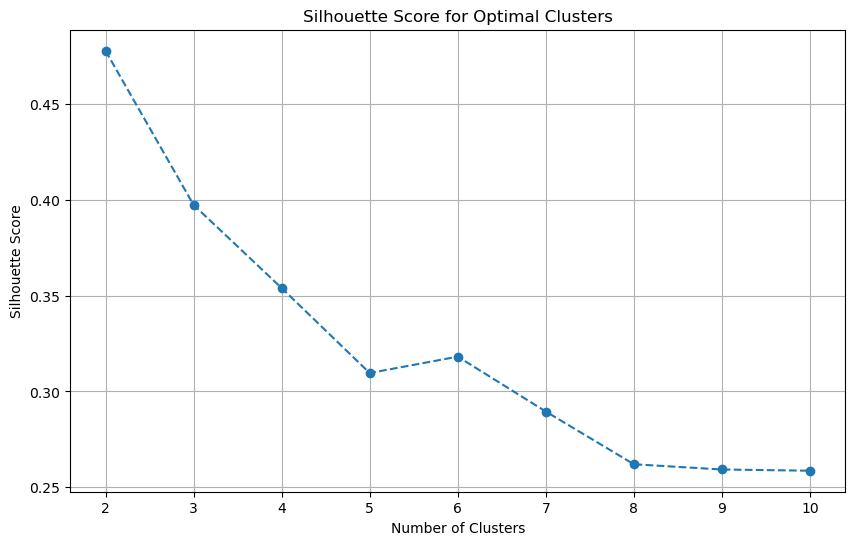

In [29]:

silhouette_scores = []
cluster_range = range(2,11)
for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', n_init=10, random_state=0)
    labels = kmeans.fit_predict(data)
    silhouette_scores.append(silhouette_score(data, labels))

# Plot Silhouette Scores
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, silhouette_scores, marker='o', linestyle='--')
plt.title('Silhouette Score for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.grid()
plt.show()


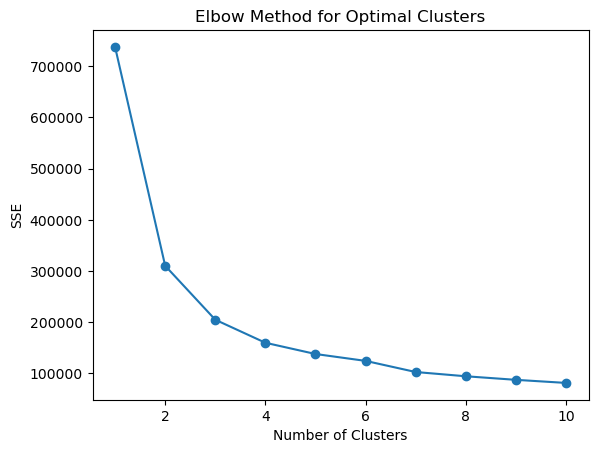

3


In [30]:

import matplotlib.pyplot as plt

def find_optimal_clusters(df, max_clusters=10):
    sse = []  # Sum of Squared Errors (SSE)
    
    for k in range(1, max_clusters + 1):
        kmeans = KMeans(n_clusters=k, init='k-means++', random_state=0)
        kmeans.fit(df)
        sse.append(kmeans.inertia_)
    
    # Plot Elbow Curve
    plt.plot(range(1, max_clusters + 1), sse, marker='o')
    plt.xlabel('Number of Clusters')
    plt.ylabel('SSE')
    plt.title('Elbow Method for Optimal Clusters')
    plt.show()

    # Optimal clusters using "elbow" point
    optimal_clusters = sse.index(min(sse[1:], key=lambda x: abs(x - sse[0]))) + 2
    return optimal_clusters
cluster = find_optimal_clusters(data)
print(cluster)

In [31]:
from sklearn.cluster import KMeans
initial_centroids='k-means++'
if 'cluster' in data.columns:
    data = data.drop('cluster', axis=1)

def get_clusters(df):
    df['cluster'] = KMeans(n_clusters=cluster,
                           random_state=0,
                           init=initial_centroids).fit(df).labels_
    return df

data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)

data

garman_klass_vol        rsi    bb_low    bb_mid  \
date       ticker                                                           
2019-04-30 ACC.NS                -0.000955  55.485690  7.321047  7.352606   
           ADANIENT.NS            0.000456  39.218585  4.848562  4.941204   
           ADANIPORTS.NS         -0.000124  61.250640  5.895141  5.922220   
           AMBUJACEM.NS          -0.006295  46.827571  5.287404  5.320973   
           ASHOKLEY.NS           -0.012177  43.048476  4.285850  4.352271   
...                                    ...        ...       ...       ...   
2025-03-31 WIPRO.NS               0.000623  36.294362  5.535295  5.638162   
           YESBANK.NS             0.000123  46.643987  2.812881  2.883942   
           HDFCLIFE.NS            0.000157  67.403129  6.388027  6.447132   
           BANDHANBNK.NS          0.000224  50.277380  4.901062  4.961170   
           IRCTC.NS               0.000110  49.293226  6.502507  6.553276   

                           bb_high       atr      macd  return_1m  return_2m  \
date       ticker                                                              
2019-04-30 ACC.NS         7.384164 -0.561385  0.543411   0.008808   0.081250   
           ADANIENT.NS    5.033846 -0.880794 -0.140548  -0.078012  -0.007009   
           ADANIPORTS.NS  5.949298 -1.029384  0.257719   0.030160   0.097936   
           AMBUJACEM.NS   5.354542 -0.685328 -0.123066  -0.048954   0.019730   
           ASHOKLEY.NS    4.418693 -1.062402 -0.132671  -0.018623   0.002598   
...                            ...       ...       ...        ...        ...   
2025-03-31 WIPRO.NS       5.741029  1.720161 -2.744217  -0.048082  -0.079464   
           YESBANK.NS     2.955004 -0.742023  0.107092   0.025075  -0.055079   
           HDFCLIFE.NS    6.506236  0.010229  0.846653   0.116845   0.032047   
           BANDHANBNK.NS  5.021277 -1.189172  0.048372   0.026702  -0.021435   
           IRCTC.NS       6.604045 -0.054481 -0.674884   0.076384  -0.060904   

                          return_3m  return_6m  return_9m  return_12m  \
date       ticker                                                       
2019-04-30 ACC.NS          0.053200   0.032208   0.009311    0.005685   
           ADANIENT.NS    -0.025176  -0.047377   0.001449    0.029522   
           ADANIPORTS.NS   0.050687   0.035375  -0.001947   -0.002598   
           AMBUJACEM.NS    0.018963   0.020035  -0.004228   -0.010039   
           ASHOKLEY.NS     0.022648  -0.045115  -0.028506   -0.048770   
...                             ...        ...        ...         ...   
2025-03-31 WIPRO.NS       -0.037020  -0.000724   0.005128    0.009706   
           YESBANK.NS     -0.043000  -0.043917  -0.035133   -0.024770   
           HDFCLIFE.NS     0.032708  -0.009119   0.014872    0.006175   
           BANDHANBNK.NS  -0.030467  -0.051231  -0.036318   -0.017254   
           IRCTC.NS       -0.026857  -0.039561  -0.032918   -0.019733   

                            Mkt-RF       SMB       HML       RMW       CMA  \
date       ticker                                                            
2019-04-30 ACC.NS         0.060707 -0.291804  0.411893  0.449363 -0.405692   
           ADANIENT.NS    0.449927  0.152187 -0.221560  0.397400 -0.450886   
           ADANIPORTS.NS  0.392839  0.389315  0.358161  0.175044 -0.455156   
           AMBUJACEM.NS   0.071818 -0.700060  0.457234 -0.884894  0.569596   
           ASHOKLEY.NS    0.409284  0.302229  0.736824 -0.209679 -0.611358   
...                            ...       ...       ...       ...       ...   
2025-03-31 WIPRO.NS       0.630505 -0.210519 -0.099473 -0.556812  0.030059   
           YESBANK.NS     0.023858  1.754943 -0.295232  1.026292 -0.039517   
           HDFCLIFE.NS    0.542061 -0.118130  0.067689 -0.116070  0.072551   
           BANDHANBNK.NS  0.146615 -0.749403  0.857076 -1.110054 -0.590353   
           IRCTC.NS       0.427896 -0.519286  1.091179 -0.948486 -0.853444   

                  

In [32]:
data['cluster'].value_counts()

cluster
0    2250
2    1923
1    1788
Name: count, dtype: int64

In [33]:
def plot_clusters(data):

    cluster_0 = data[data['cluster']==0]
    cluster_1 = data[data['cluster']==1]
    cluster_2 = data[data['cluster']==2]
    # cluster_3 = data[data['cluster']==3]
    # cluster_4 = data[data['cluster']==4]
    # cluster_5 = data[data['cluster']==5]

    plt.scatter(cluster_0.iloc[:,0] , cluster_0.iloc[:,6] , color = 'red', label='cluster 0')
    plt.scatter(cluster_1.iloc[:,0] , cluster_1.iloc[:,6] , color = 'green', label='cluster 1')
    plt.scatter(cluster_2.iloc[:,0] , cluster_2.iloc[:,6] , color = 'blue', label='cluster 2')
    # plt.scatter(cluster_3.iloc[:,0] , cluster_3.iloc[:,6] , color = 'black', label='cluster 3')
    
    plt.legend()
    plt.show()
    return


In [34]:
data.describe()

,garman_klass_vol,rsi,bb_low,bb_mid,bb_high,atr,macd,return_1m,return_2m,return_3m,return_6m,return_9m,return_12m,Mkt-RF,SMB,HML,RMW,CMA,cluster
count,5961.000000,5961.000000,5961.000000,5961.000000,5961.000000,5961.000000,5961.000000,5961.000000,5961.000000,5961.000000,5961.000000,5961.000000,5961.000000,5961.000000,5961.000000,5961.000000,5961.000000,5961.000000,5961.000000
mean,-0.005381,51.967472,6.210811,6.279921,6.349032,0.188595,-0.021767,0.019457,0.015937,0.015054,0.014138,0.013999,0.013691,0.524404,0.131327,0.387048,-0.186720,-0.224746,0.945143
std,0.030949,10.387961,1.482766,1.469974,1.458975,0.976518,1.072723,0.158494,0.088567,0.069085,0.047723,0.039396,0.034305,1.067452,1.183829,0.747928,1.806983,0.947436,0.834960
min,-0.349657,17.856023,1.253202,1.549630,1.754619,-2.027263,-6.231783,-0.527822,-0.418816,-0.344070,-0.236978,-0.177867,-0.174320,-14.157459,-3.982076,-3.776719,-4.325240,-6.396898,0.000000
25%,-0.000803,44.586934,5.151580,5.229431,5.301549,-0.534414,-0.606418,-0.043422,-0.029042,-0.020357,-0.012448,-0.008323,-0.005392,0.301648,-0.377715,-0.036276,-0.750993,-0.740288,0.000000
50%,0.000066,51.895050,6.400449,6.467183,6.527803,0.006093,-0.021656,0.011676,0.012917,0.012981,0.012970,0.011903,0.012674,0.535463,0.034148,0.358161,-0.306260,-0.217834,1.000000
75%,0.000310,59.294038,7.281624,7.354861,7.407644,0.741276,0.560020,0.072115,0.056358,0.048952,0.038159,0.034956,0.032178,0.838300,0.439206,0.809074,0.164641,0.206503,2.000000
max,0.060874,84.867881,9.406439,9.449749,9.498979,6.637897,5.993061,8.878215,2.543333,1.323032,0.538925,0.333776,0.250148,3.203679,16.996503,7.066087,26.974747,12.030636,2.000000


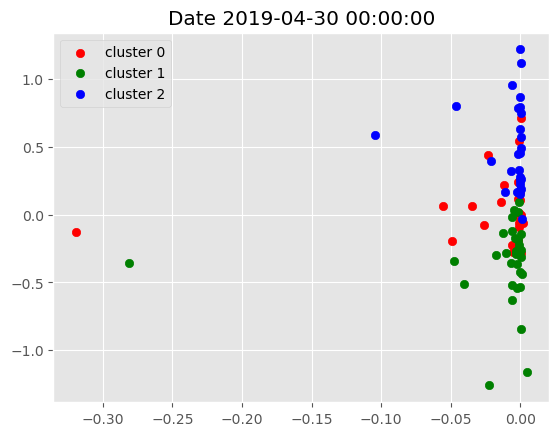

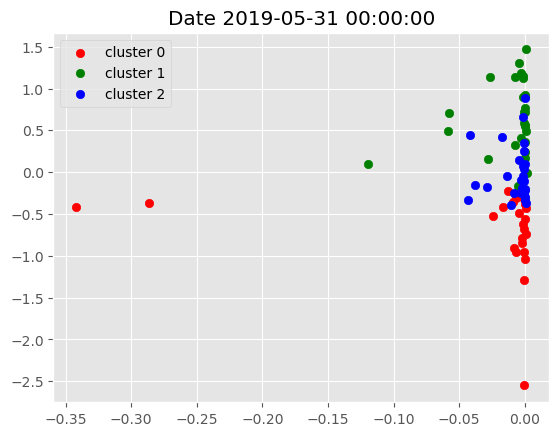

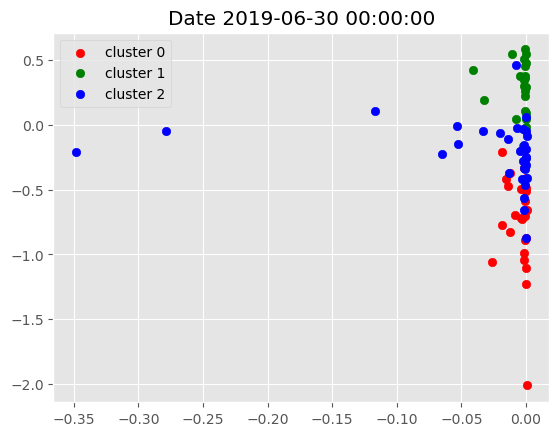

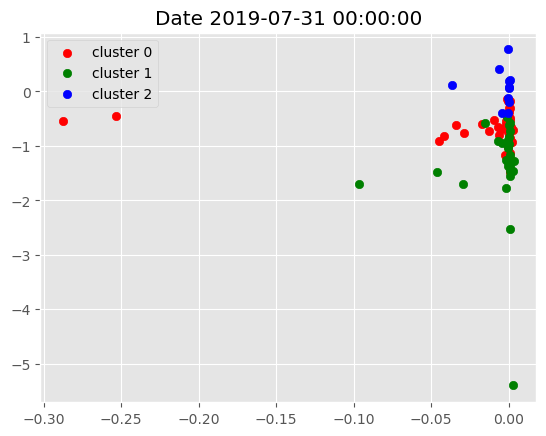

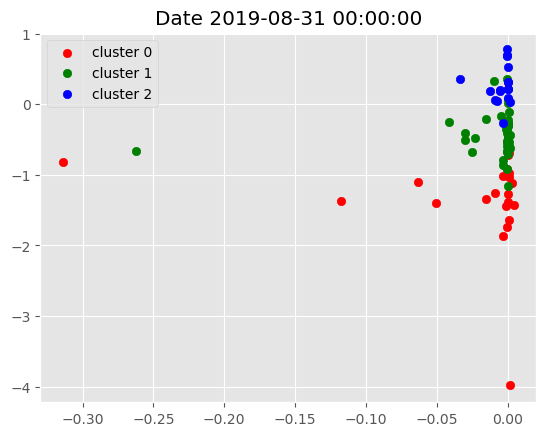

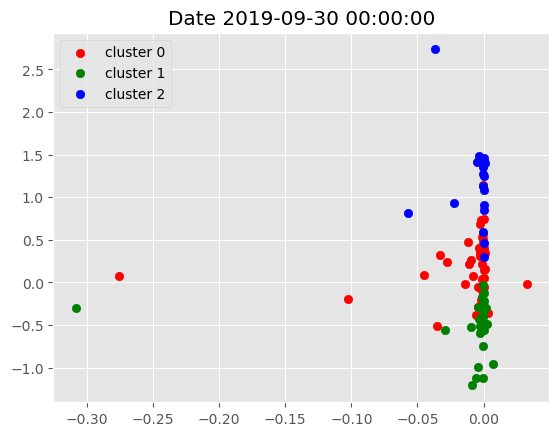

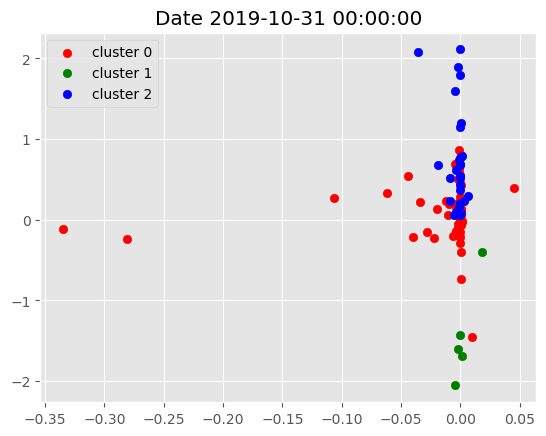

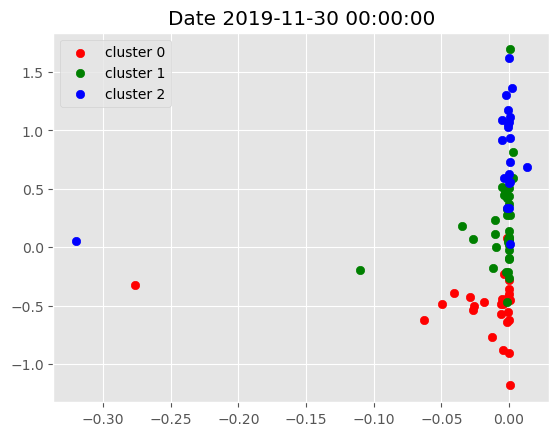

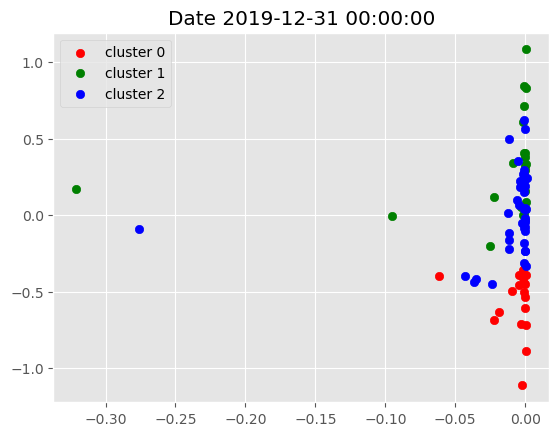

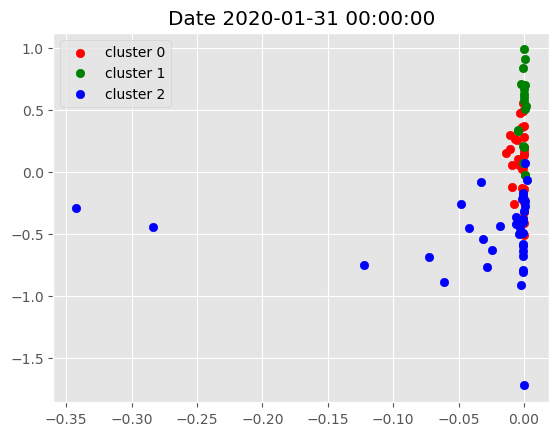

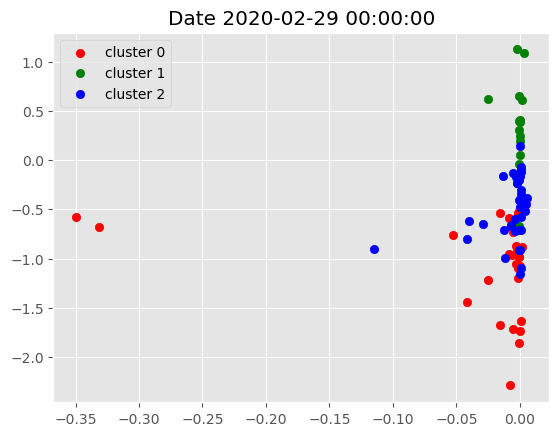

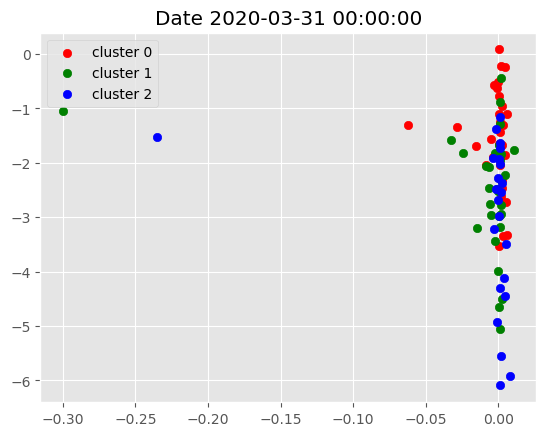

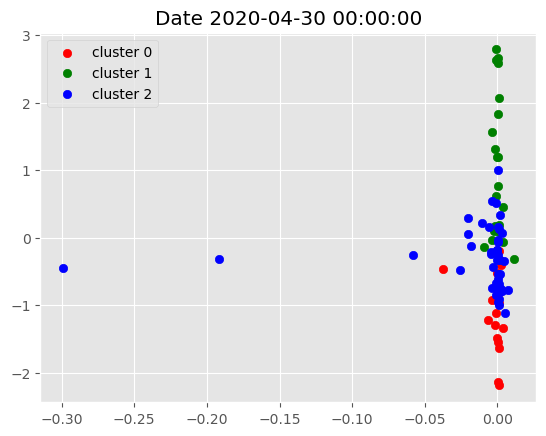

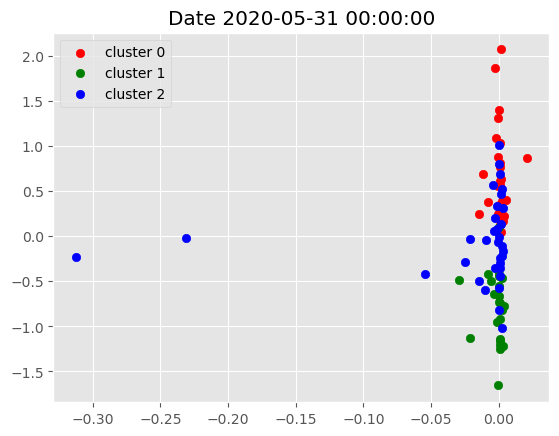

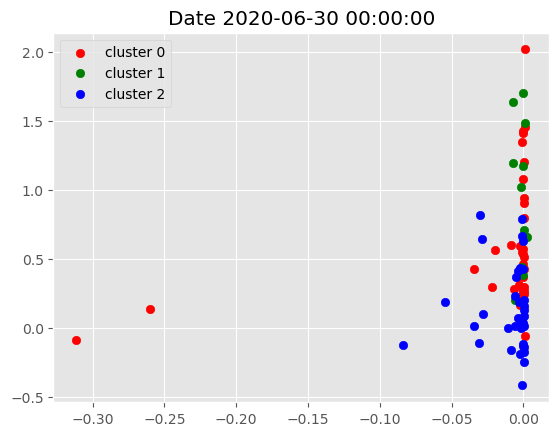

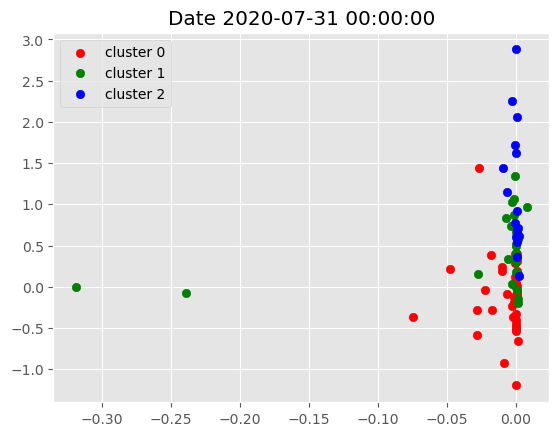

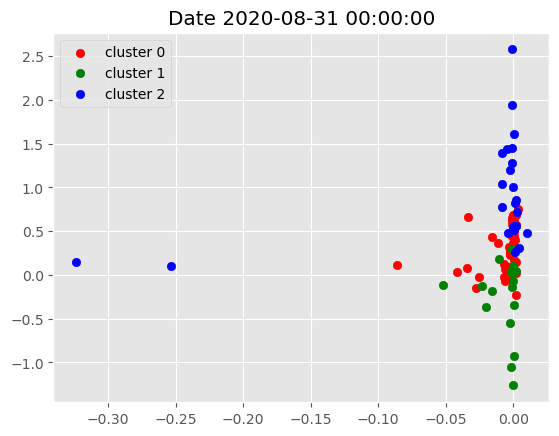

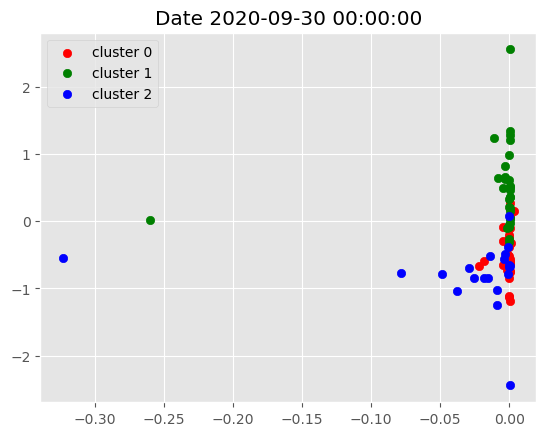

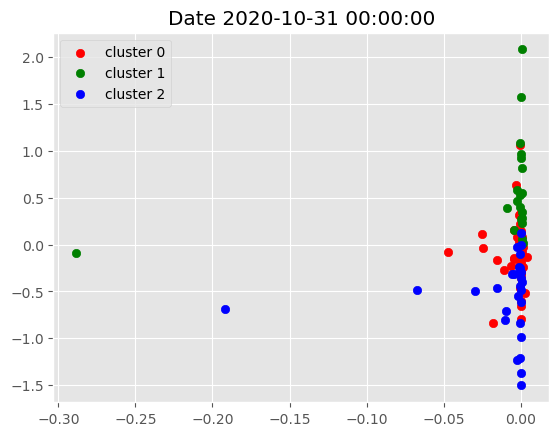

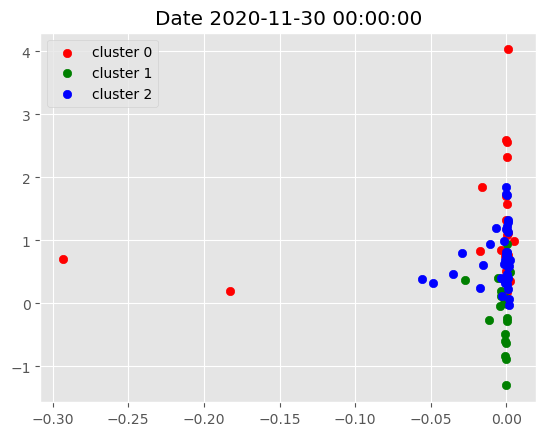

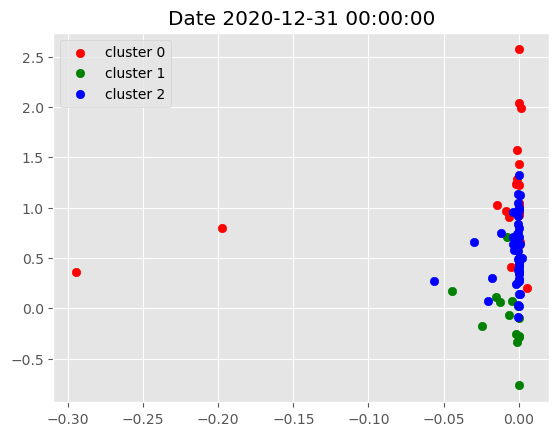

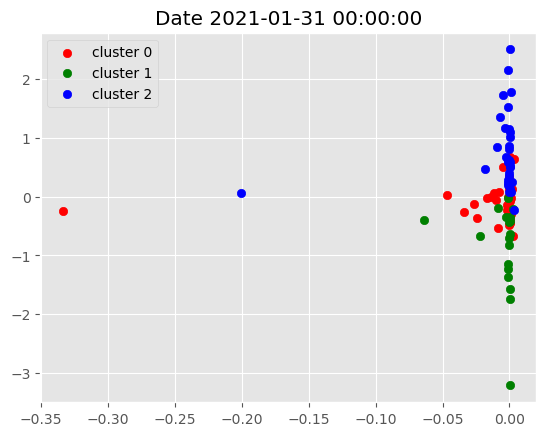

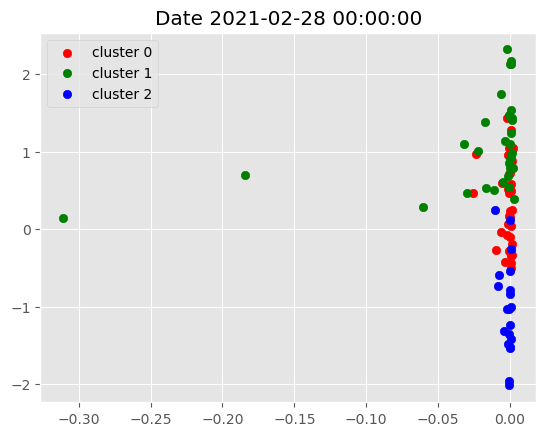

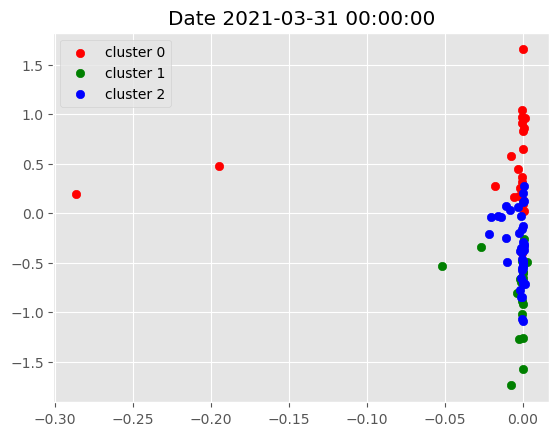

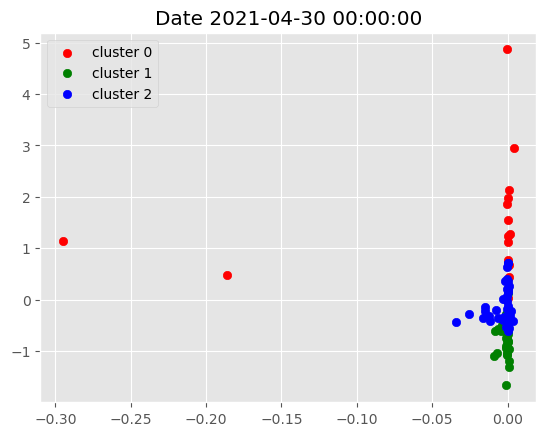

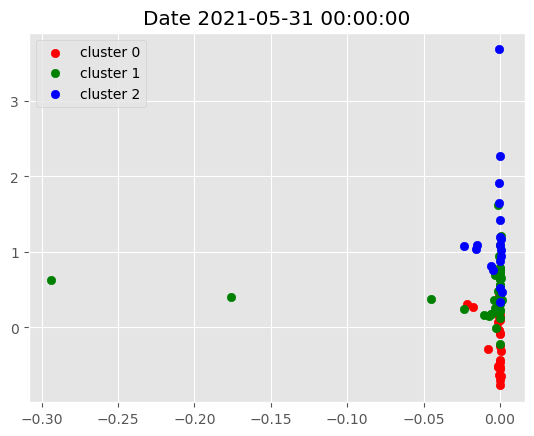

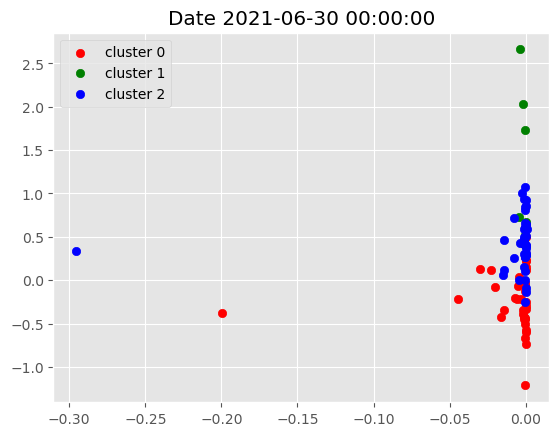

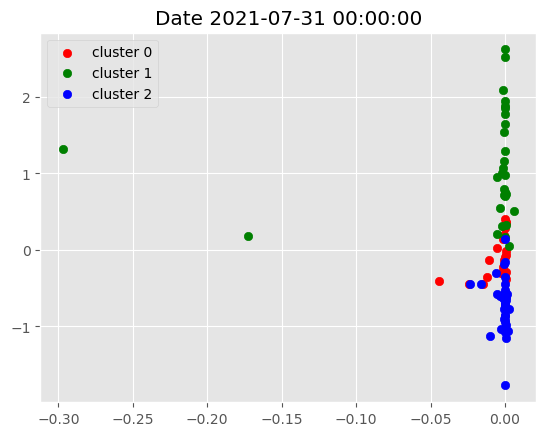

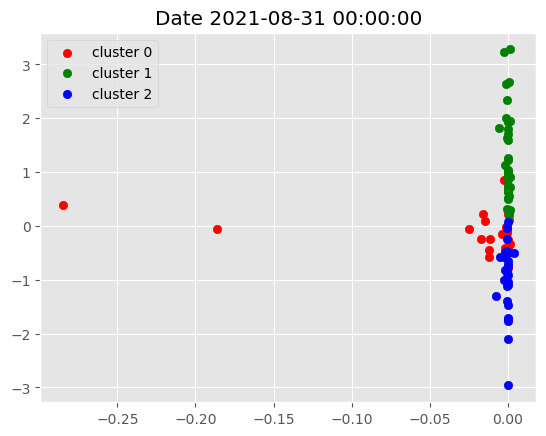

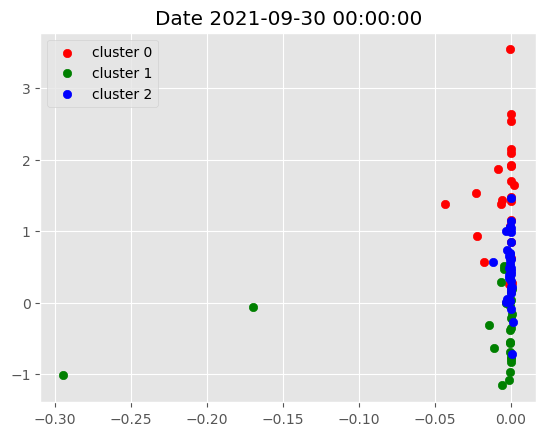

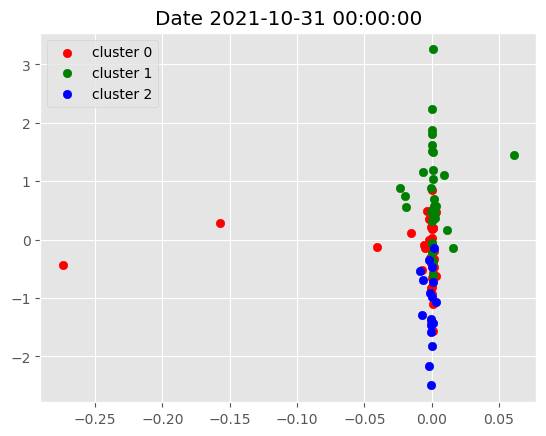

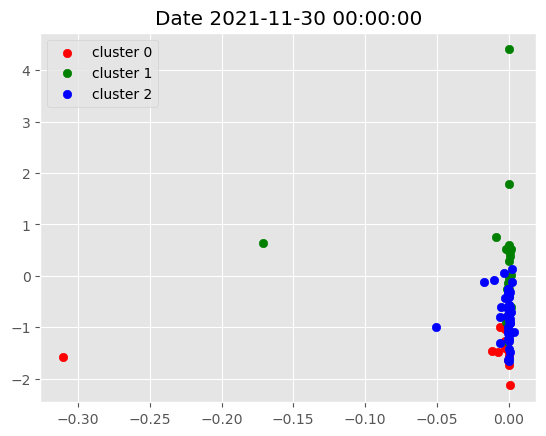

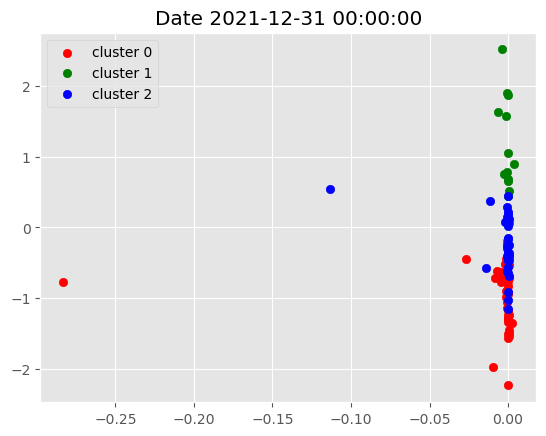

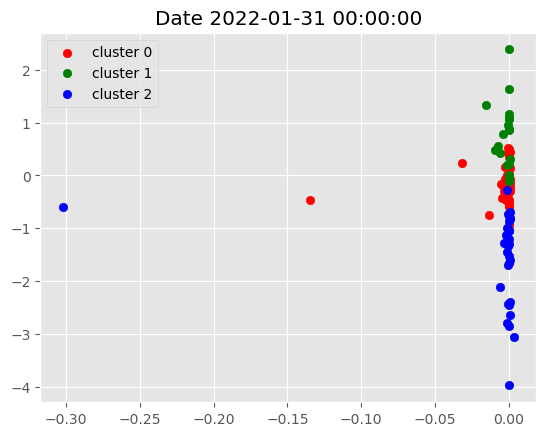

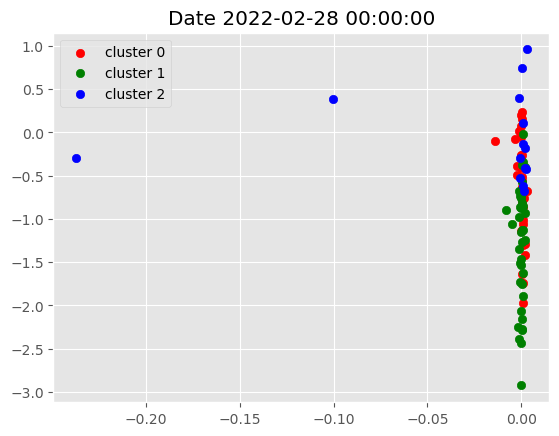

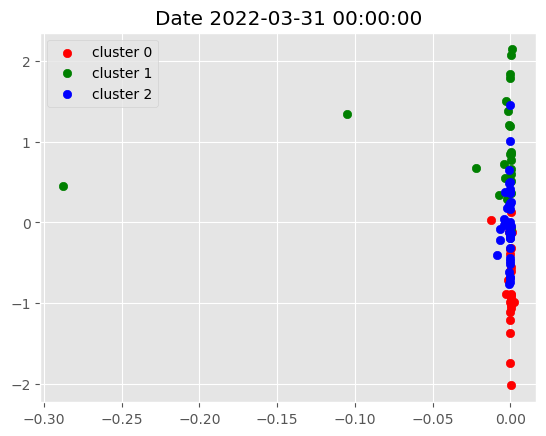

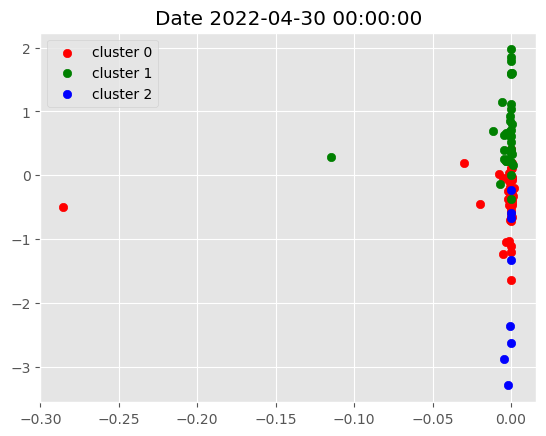

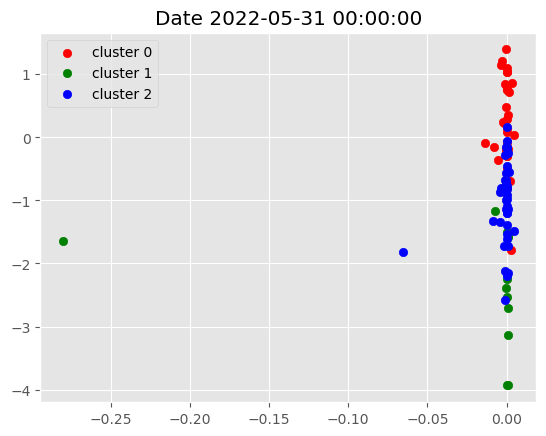

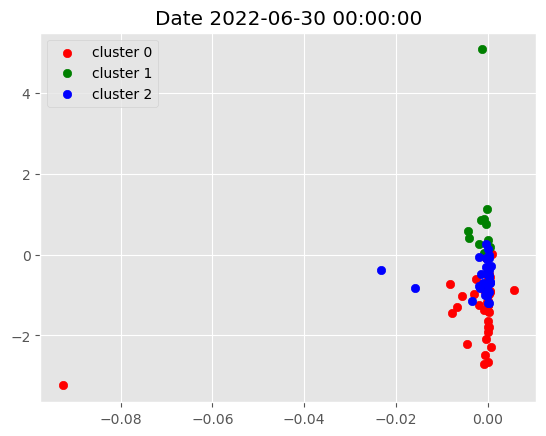

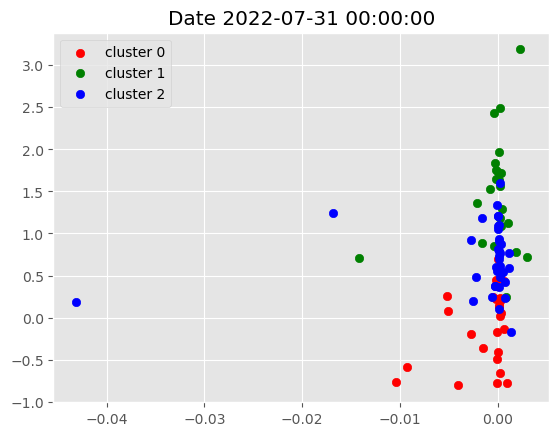

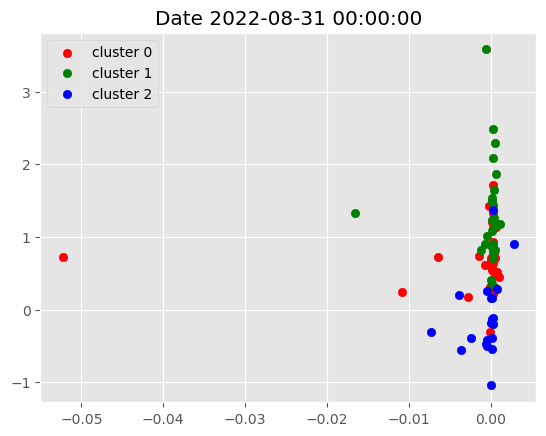

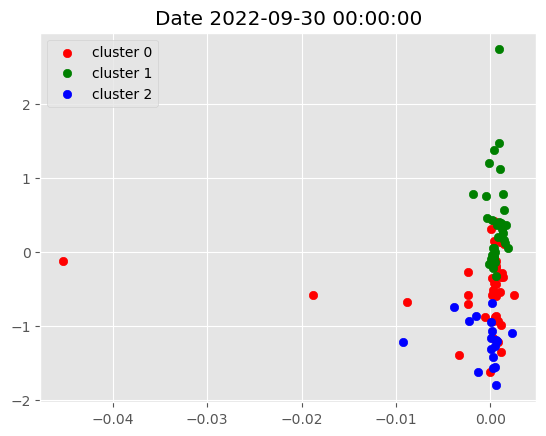

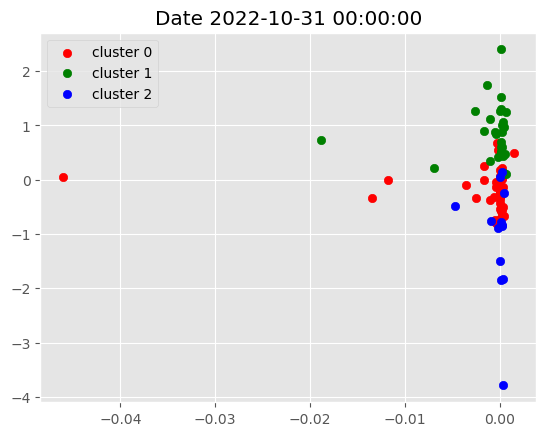

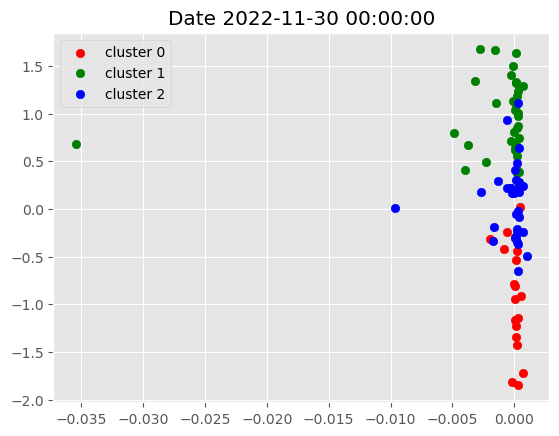

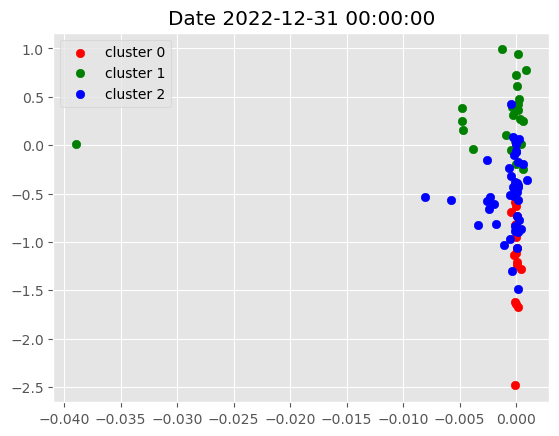

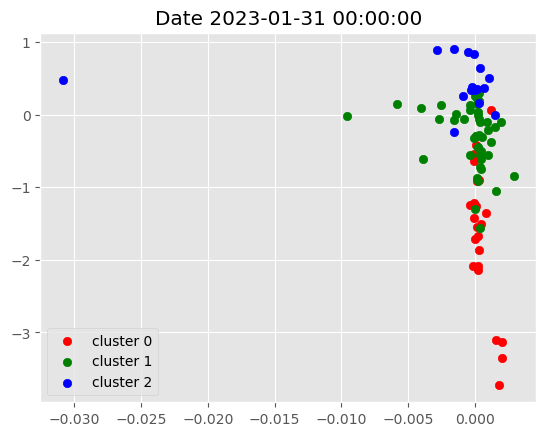

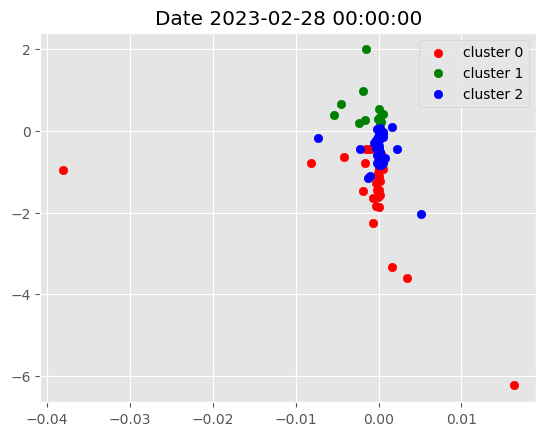

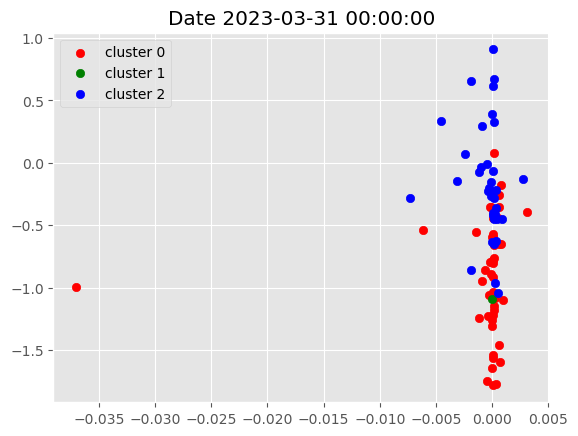

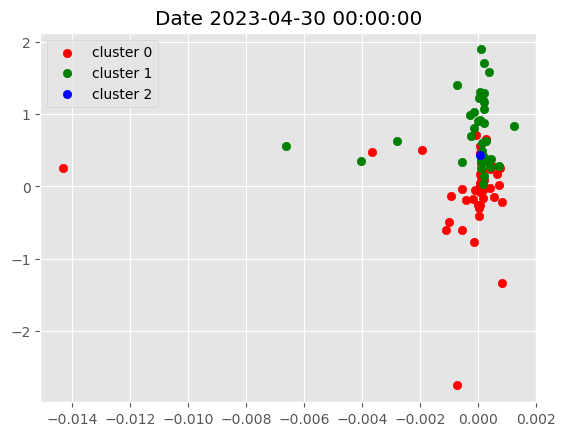

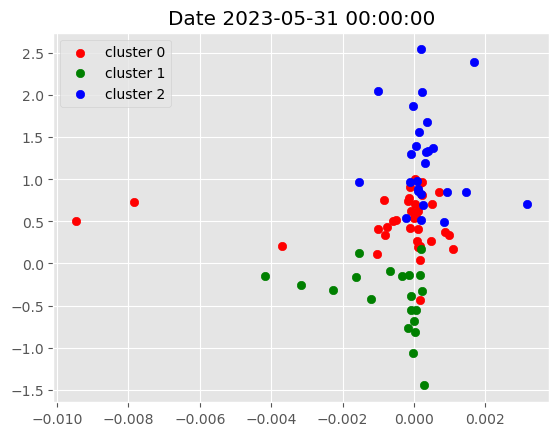

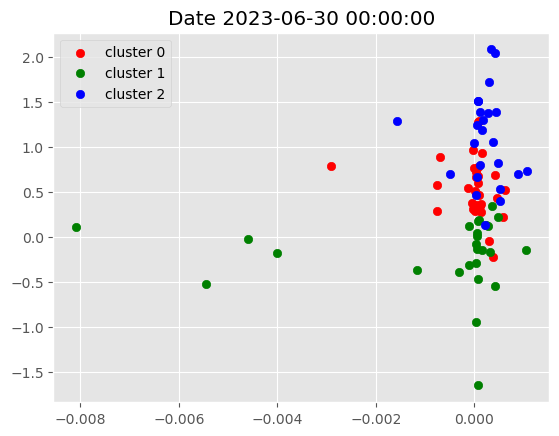

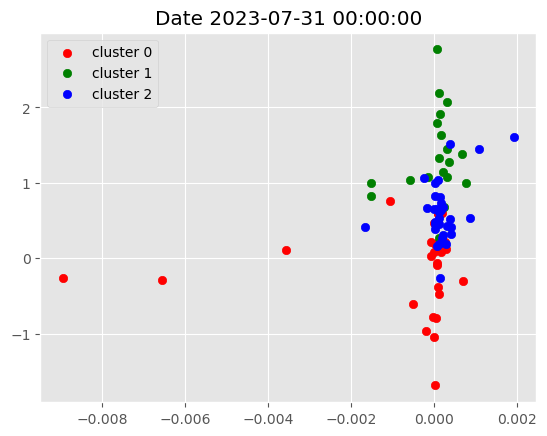

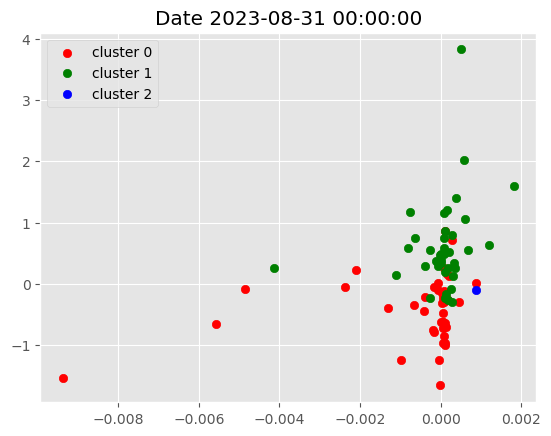

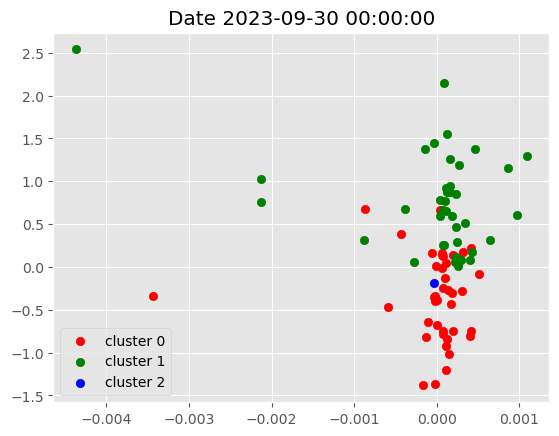

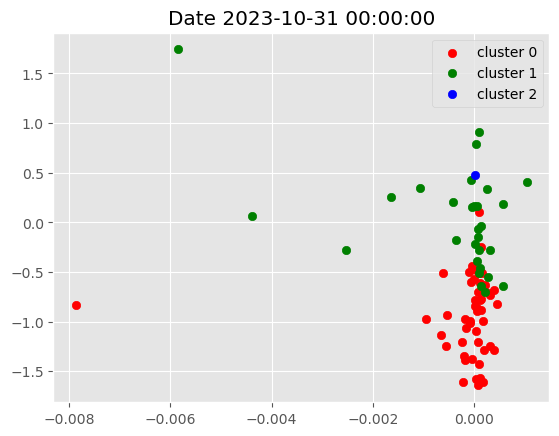

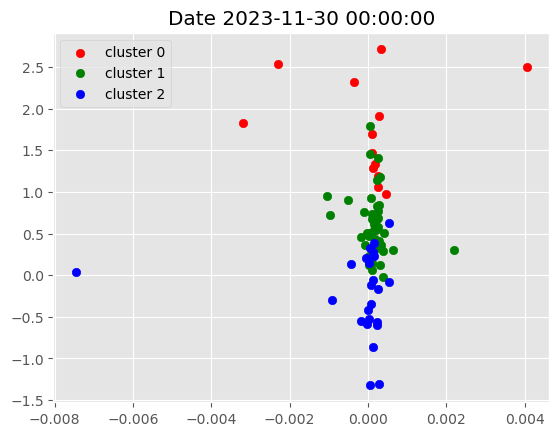

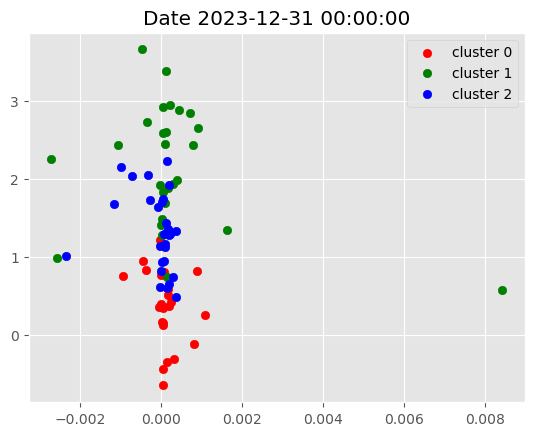

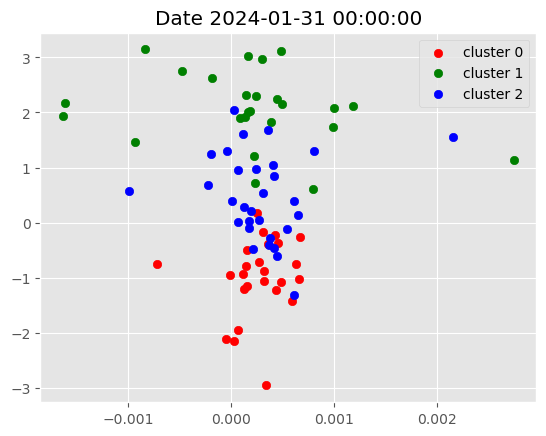

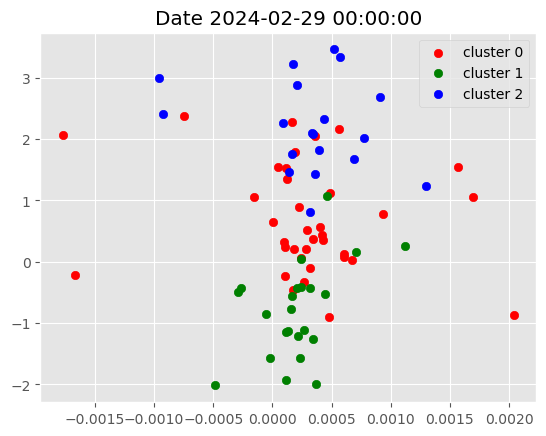

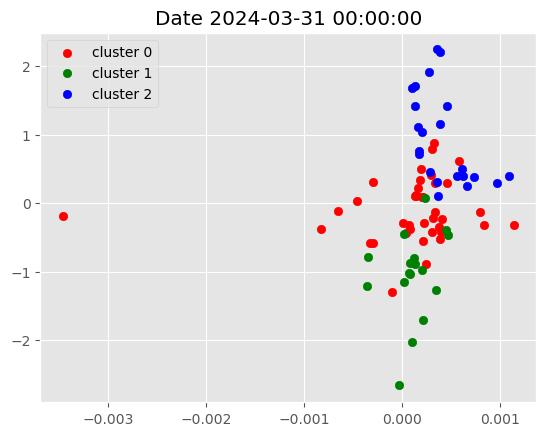

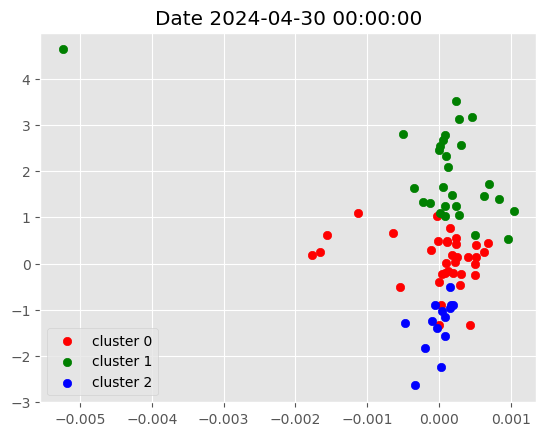

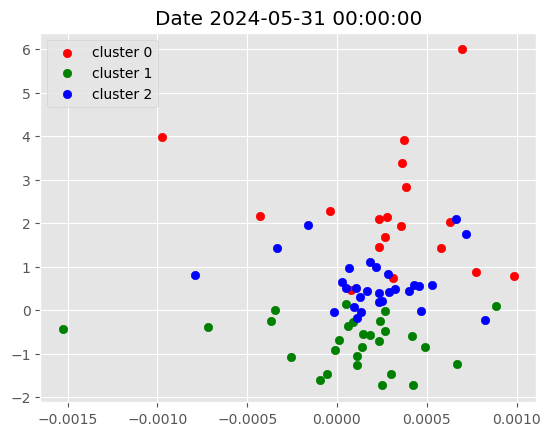

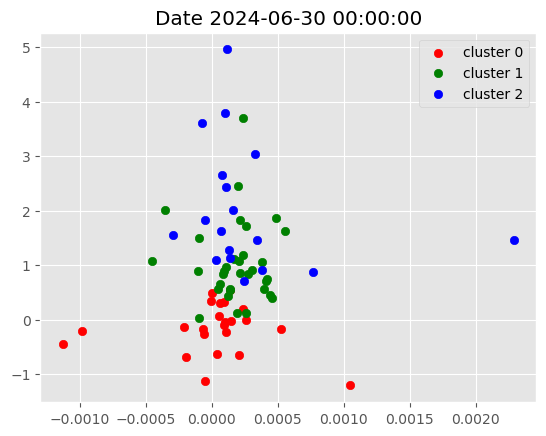

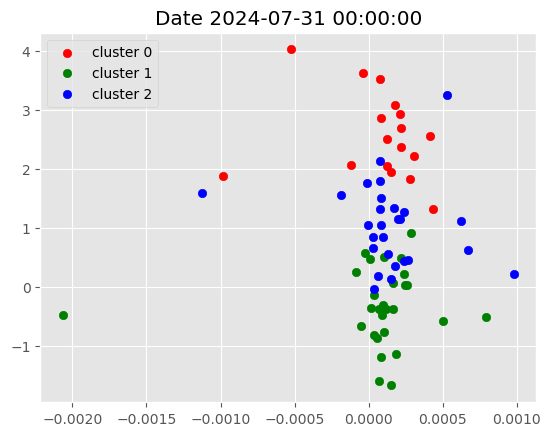

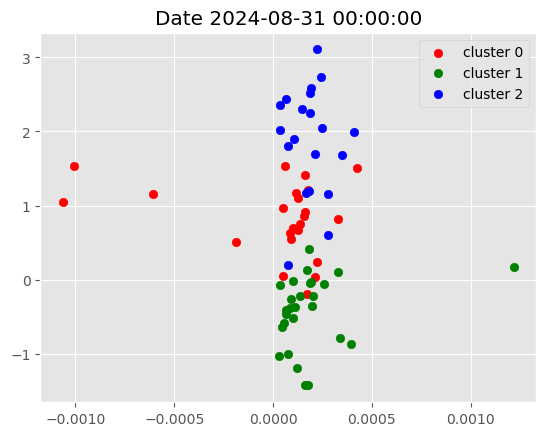

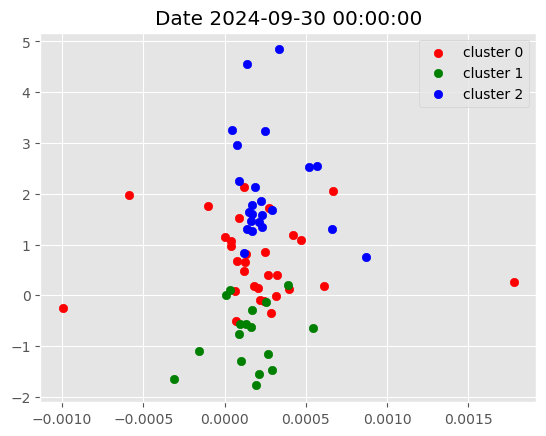

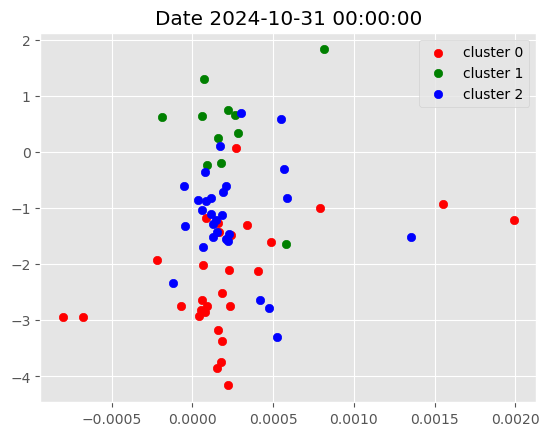

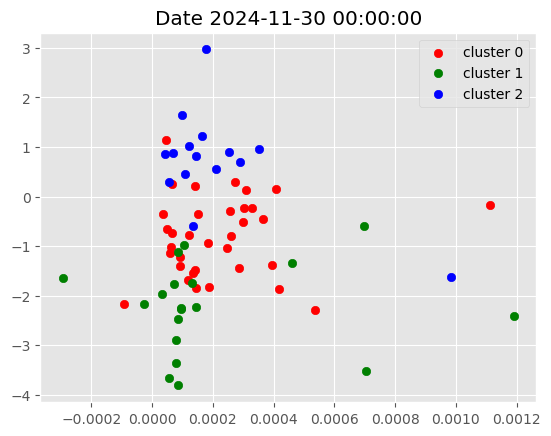

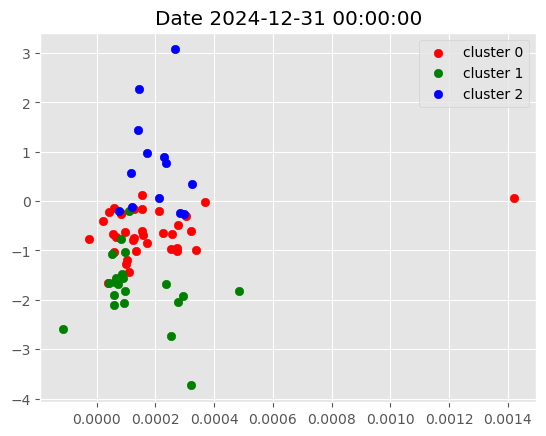

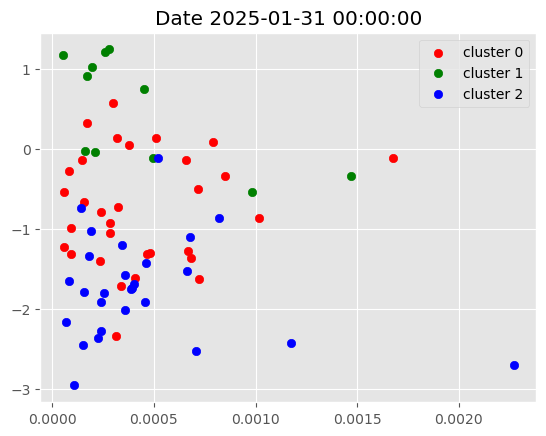

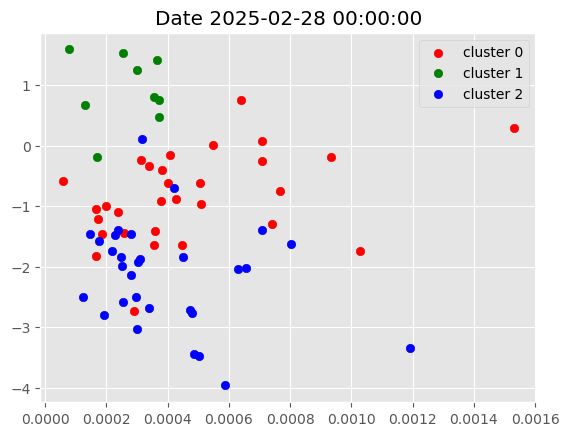

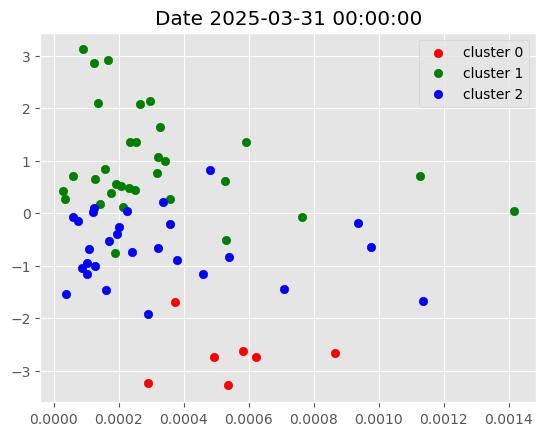

In [35]:
plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():
    
    g = data.xs(i, level=0)
    
    plt.title(f'Date {i}')
    
    plot_clusters(g)

### Apply pre-defined centroids.

In [37]:

# Define RSI-based centroids
target_rsi_values = [30, 45, 55, 70]
initial_centroids = np.zeros((len(target_rsi_values), 18))
initial_centroids[:, 6] = target_rsi_values

# Select optimal cluster dynamically (optional)
best_cluster = data.groupby('cluster')['return_1m'].mean().idxmax()
filtered_df = data[data['cluster'] == best_cluster].copy()

# Prepare filtered dataframe with shifted dates
filtered_df = filtered_df.reset_index(level=1)
filtered_df.index = filtered_df.index + pd.DateOffset(1)  # Shift date to next month
filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])

# Generate fixed_dates dictionary
dates = filtered_df.index.get_level_values('date').unique().tolist()
fixed_dates = {d.strftime('%Y-%m-%d'): filtered_df.xs(d, level=0).index.tolist() for d in dates}

fixed_dates
# print(len(fixed_dates))

{'2019-05-01': ['ADANIENT.NS',
  'AMBUJACEM.NS',
  'ASHOKLEY.NS',
  'BANKBARODA.NS',
  'BEL.NS',
  'BIOCON.NS',
  'BRITANNIA.NS',
  'CANBK.NS',
  'COFORGE.NS',
  'DLF.NS',
  'DMART.NS',
  'EICHERMOT.NS',
  'ESCORTS.NS',
  'HEROMOTOCO.NS',
  'IDEA.NS',
  'INDUSINDBK.NS',
  'INDUSTOWER.NS',
  'JUBLFOOD.NS',
  'LICHSGFIN.NS',
  'LTF.NS',
  'M&M.NS',
  'M&MFIN.NS',
  'MARUTI.NS',
  'MOTHERSON.NS',
  'PNB.NS',
  'POWERGRID.NS',
  'SHRIRAMFIN.NS',
  'TATAELXSI.NS',
  'VEDL.NS',
  'YESBANK.NS'],
 '2019-06-01': ['ADANIENT.NS',
  'ADANIPORTS.NS',
  'AXISBANK.NS',
  'BAJAJFINSV.NS',
  'BAJFINANCE.NS',
  'BANKBARODA.NS',
  'BEL.NS',
  'BHARTIARTL.NS',
  'BPCL.NS',
  'COALINDIA.NS',
  'DLF.NS',
  'FEDERALBNK.NS',
  'GAIL.NS',
  'HDFCBANK.NS',
  'HINDPETRO.NS',
  'HINDUNILVR.NS',
  'ICICIBANK.NS',
  'INDIGO.NS',
  'IOC.NS',
  'KOTAKBANK.NS',
  'LICHSGFIN.NS',
  'LT.NS',
  'SBIN.NS',
  'TATACONSUM.NS',
  'TCS.NS',
  'TITAN.NS',
  'ULTRACEMCO.NS',
  'UPL.NS'],
 '2019-07-01': ['AXISBANK.NS',
  'BAJAJF

## 7. For each month select assets based on the cluster and form a portfolio based on Efficient Frontier max sharpe ratio optimization

* First we will filter only stocks corresponding to the cluster we choose based on our hypothesis.

* Momentum is persistent and my idea would be that stocks clustered around RSI 70 centroid should continue to outperform in the following month - thus I would select stocks corresponding to cluster 3.


In [39]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

def optimize_weights(prices, lower_bound=0):
    
    returns = expected_returns.mean_historical_return(prices=prices,
                                                      frequency=252)
    
    cov = risk_models.sample_cov(prices=prices,
                                 frequency=252)
    
    ef = EfficientFrontier(expected_returns=returns,
                           cov_matrix=cov,
                           weight_bounds=(lower_bound, .1),
                           solver='SCS')
    
    weights = ef.max_sharpe()
    
    return ef.clean_weights()


### Define portfolio optimization function

* We will define a function which optimizes portfolio weights using PyPortfolioOpt package and EfficientFrontier optimizer to maximize the sharpe ratio.

* To optimize the weights of a given portfolio we would need to supply last 1 year prices to the function.

* Apply signle stock weight bounds constraint for diversification (minimum half of equaly weight and maximum 10% of portfolio).

* Download Fresh Daily Prices Data only for short listed stocks.

In [42]:
stocks = data.index.get_level_values('ticker').unique().tolist()

new_df = yf.download(tickers=stocks,
                     start=data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12),
                     end=data.index.get_level_values('date').unique()[-1],
                    auto_adjust=False)

new_df

[*********************100%***********************]  97 of 97 completed


Price         Adj Close                                                        \
Ticker           ACC.NS  ADANIENT.NS ADANIPORTS.NS AMBUJACEM.NS APOLLOHOSP.NS   
Date                                                                            
2018-04-30  1442.771240    88.466423    390.777435   223.256470   1064.932495   
2018-05-02  1415.500366    81.709877    384.828949   218.624786   1054.244385   
2018-05-03  1397.910645    79.815529    380.895294   213.725861   1043.750732   
2018-05-04  1388.774902    79.941811    391.688934   210.831070   1075.083984   
2018-05-07  1384.911499    80.573273    395.670532   209.539520   1055.073853   
...                 ...          ...           ...          ...           ...   
2025-03-17  1883.099976  2252.699951   1137.150024   490.549988   6156.649902   
2025-03-18  1883.099976  2252.699951   1137.150024   490.549988   6156.649902   
2025-03-19  1900.000000  2318.649902   1173.500000   507.049988   6427.549805   
2025-03-20  1889.599976  2339.300049   1177.449951   504.700012   6474.350098   
2025-03-21  1915.650024  2362.800049   1188.800049   514.500000   6611.549805   

Price                                                                          \
Ticker     ASHOKLEY.NS ASIANPAINT.NS AUROPHARMA.NS  AXISBANK.NS BAJAJ-AUTO.NS   
Date                                                                            
2018-04-30  133.513733   1138.767822    616.872070   514.416992   2428.266846   
2018-05-02  131.078079   1158.289062    608.464661   520.830994   2439.246094   
2018-05-03  132.945419   1143.553467    594.436096   530.427307   2446.853271   
2018-05-04  133.107773   1128.107056    588.478760   517.400269   2375.673096   
2018-05-07  134.244446   1151.608032    596.501892   533.112183   2397.591064   
...                ...           ...           ...          ...           ...   
2025-03-17  198.460007   2219.550049   1111.699951  1034.150024   7486.049805   
2025-03-18  198.460007   2219.550049   1111.699951  1034.150024   7486.049805   
2025-03-19  205.690002   2280.699951   1163.800049  1052.050049   7721.850098   
2025-03-20  207.479996   2287.199951   1174.150024  1054.349976   7920.000000   
2025-03-21  210.839996   2300.399902   1200.349976  1070.150024   8067.850098   

Price       ...   Volume                                                       \
Ticker      ...   TCS.NS TECHM.NS TITAN.NS TVSMOTOR.NS ULTRACEMCO.NS   UPL.NS   
Date        ...                                                                 
2018-04-30  ...  3458558  2639069  1083840      404364        177986  3093207   
2018-05-02  ...  3158046  1745715  1027474      992251        217139  1442760   
2018-05-03  ...  3761550  2284475  1585290      899907        146828  2562340   
2018-05-04  ...  2347244  3162498   958663     1794176        212463  1587040   
2018-05-07  ...  3484426  2770174  1987395      755242        133722  1563171   
...         ...      ...      ...      ...         ...           ...      ...   
2025-03-17  ...  2690906  1747569   632348      582066        212061  2377362   
2025-03-18  ...        0        0        0           0             0        0   
2025-03-19  ...  3051244  5557840   730983      610676        269175  1533871   
2025-03-20  ...  2845192  2863413  1542807      597377        549251  1272076   
2025-03-21  ...  4161925  4056023  1181974     1871573        656565  5231169   

Price                                                
Ticker       VEDL.NS VOLTAS.NS  WIPRO.NS YESBANK.NS  
Date                                                 
2018-04-30   6843221    826570   5648769   28400085  
2018-05-02  12277622    564733   6354939   13058846  
2018-05-03  13002792   1108658   8949440   15431044  
2018-05-04  16087098    964694   8256123   12241946  
2018-05-07   8242354   1211109   5265878    6781161  
...              ...       ...       ...        ...  
2025-03-17   4865003   1881080  12697926   71732487  
2025-03-18         0         0         0          0  
2

* Calculate daily returns for each stock which could land up in our portfolio.

* Then loop over each month start, select the stocks for the month and calculate their weights for the next month.

* If the maximum sharpe ratio optimization fails for a given month, apply equally-weighted weights.

* Calculated each day portfolio return.

In [44]:
returns_dataframe = np.log(new_df['Adj Close']).diff()

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():
    
    try:

        end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')

        cols = fixed_dates[start_date]

        optimization_start_date = (pd.to_datetime(start_date)-pd.DateOffset(months=12)).strftime('%Y-%m-%d')

        optimization_end_date = (pd.to_datetime(start_date)-pd.DateOffset(days=1)).strftime('%Y-%m-%d')
        
        optimization_df = new_df.loc[optimization_start_date:optimization_end_date]['Adj Close'][cols]
        
        success = False
        try:
            weights = optimize_weights(prices=optimization_df,
                                   lower_bound=round(1/(len(optimization_df.columns)*2),4))

            weights = pd.DataFrame(weights, index=pd.Series(0))
            
            success = True
        except:
            print(f'Max Sharpe Optimization failed for {start_date}, Continuing with Equal-Weights')
        
        if success==False:
            weights = pd.DataFrame([1/len(optimization_df.columns) for i in range(len(optimization_df.columns))],
                                     index=optimization_df.columns.tolist(),
                                     columns=pd.Series(0)).T
        
        temp_df = returns_dataframe[start_date:end_date]

        temp_df = temp_df.stack().to_frame('return').reset_index(level=0)\
                   .merge(weights.stack().to_frame('weight').reset_index(level=0, drop=True),
                          left_index=True,
                          right_index=True)\
                   .reset_index().set_index(['Date', 'Ticker']).unstack().stack()

        temp_df.index.names = ['date', 'ticker']

        temp_df['weighted_return'] = temp_df['return']*temp_df['weight']

        temp_df = temp_df.groupby(level=0)['weighted_return'].sum().to_frame('Strategy Return')

        portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)
    
    except Exception as e:
        print(e)

portfolio_df = portfolio_df.drop_duplicates()

portfolio_df

Max Sharpe Optimization failed for 2019-05-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2019-08-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2019-10-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2019-11-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2020-04-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2020-06-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2021-07-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2022-06-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2023-04-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2025-03-01, Continuing with Equal-Weights
'return'


,Strategy Return
date,
2019-05-02,-0.004828
2019-05-03,-0.000421
2019-05-06,-0.013997
2019-05-07,-0.013194
2019-05-08,-0.012818
...,...
2025-03-17,0.011261
2025-03-18,0.000000
2025-03-19,0.028226


[*********************100%***********************]  1 of 1 completed

✅ Portfolio vs Nifty Performance Metrics:
• Annualized Return (Strategy): 21.82%
• Annualized Return (Nifty): 10.36%
• Sharpe Ratio (Strategy): 0.78
• Sharpe Ratio (Nifty): 0.37
• Max Drawdown (Strategy): -36.08%
• Max Drawdown (Nifty): -40.04%


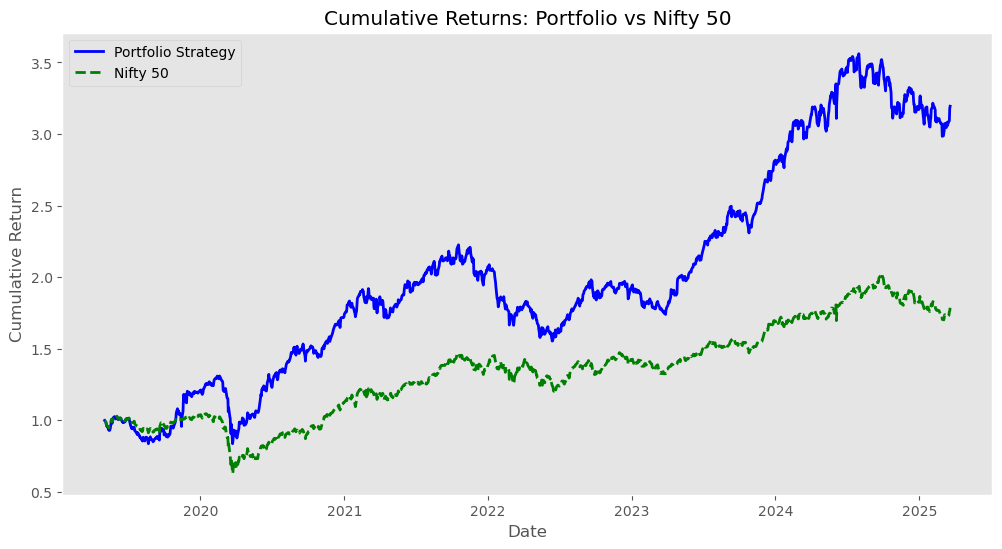

In [45]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Download Nifty 50 Data as Benchmark
benchmark_ticker = "^NSEI"  # Nifty 50 Index
nifty_data = yf.download(tickers=benchmark_ticker,
                         start=portfolio_df.index[0],
                         end=portfolio_df.index[-1],
                         auto_adjust=True)

nifty_returns = pd.DataFrame()

# Calculate Nifty Returns
nifty_returns['Nifty Return'] = np.log(nifty_data['Close']).diff().dropna()

# Merge Portfolio and Nifty Returns
comparison_df = portfolio_df.merge(nifty_returns, left_index=True, right_index=True, how='inner')

# 📊 **Recalculate Metrics for Both Strategy and Nifty**

# Cumulative Returns
comparison_df['Cumulative Strategy'] = (1 + comparison_df['Strategy Return']).cumprod()
comparison_df['Cumulative Nifty'] = (1 + comparison_df['Nifty Return']).cumprod()

# 1. Annualized Returns
n_years = (comparison_df.index[-1] - comparison_df.index[0]).days / 365
annualized_strategy = comparison_df['Cumulative Strategy'].iloc[-1] ** (1 / n_years) - 1
annualized_nifty = comparison_df['Cumulative Nifty'].iloc[-1] ** (1 / n_years) - 1

# 2. Sharpe Ratio
mean_strategy = comparison_df['Strategy Return'].mean()
std_strategy = comparison_df['Strategy Return'].std()
mean_nifty = comparison_df['Nifty Return'].mean()
std_nifty = comparison_df['Nifty Return'].std()

risk_free_rate = 0.05 / 252  # Annual risk-free rate of 5%, adjusted for daily returns

sharpe_strategy = (mean_strategy - risk_free_rate) / std_strategy * np.sqrt(252)
sharpe_nifty = (mean_nifty - risk_free_rate) / std_nifty * np.sqrt(252)

# 3. Maximum Drawdown
peak_strategy = comparison_df['Cumulative Strategy'].cummax()
drawdown_strategy = (comparison_df['Cumulative Strategy'] - peak_strategy) / peak_strategy
max_drawdown_strategy = drawdown_strategy.min()

peak_nifty = comparison_df['Cumulative Nifty'].cummax()
drawdown_nifty = (comparison_df['Cumulative Nifty'] - peak_nifty) / peak_nifty
max_drawdown_nifty = drawdown_nifty.min()

# 📊 **Display Portfolio vs Nifty Metrics**
print("✅ Portfolio vs Nifty Performance Metrics:")
print(f"• Annualized Return (Strategy): {annualized_strategy:.2%}")
print(f"• Annualized Return (Nifty): {annualized_nifty:.2%}")
print(f"• Sharpe Ratio (Strategy): {sharpe_strategy:.2f}")
print(f"• Sharpe Ratio (Nifty): {sharpe_nifty:.2f}")
print(f"• Max Drawdown (Strategy): {max_drawdown_strategy:.2%}")
print(f"• Max Drawdown (Nifty): {max_drawdown_nifty:.2%}")

# 📈 **Plot Portfolio vs Nifty Cumulative Returns**
plt.figure(figsize=(12, 6))
plt.plot(comparison_df['Cumulative Strategy'], label='Portfolio Strategy', color='blue', linewidth=2)
plt.plot(comparison_df['Cumulative Nifty'], label='Nifty 50', color='green', linestyle='--', linewidth=2)
plt.title('Cumulative Returns: Portfolio vs Nifty 50')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid()
plt.show()


## 8. Visualize Portfolio returns and compare to nifty50 returns.

In [47]:
nifty_etf = yf.download(tickers='^NSEI',
                        start='2019-01-01',
                        end=dt.date.today(),
                        auto_adjust=True)

[*********************100%***********************]  1 of 1 completed


In [48]:
nifty_etf['Close']

Ticker,^NSEI
Date,
2019-01-02,10792.500000
2019-01-03,10672.250000
2019-01-04,10727.349609
2019-01-07,10771.799805
2019-01-08,10802.150391
...,...
2025-03-17,22508.750000
2025-03-18,22834.300781
2025-03-19,22907.599609


In [49]:
# Calculate log returns for NIFTY ETF
nifty_etf_ret = np.log(nifty_etf[['Close']]).diff().dropna()

# Rename columns for simplicity
nifty_etf_ret.columns = ['NIFTY Buy&Hold']

# Ensure the indexes of both DataFrames are datetime and aligned
portfolio_df.index = pd.to_datetime(portfolio_df.index)
nifty_etf_ret.index = pd.to_datetime(nifty_etf_ret.index)

# Merge portfolio_df with nifty_etf_ret using inner join to align on dates
portfolio_df = portfolio_df.merge(nifty_etf_ret,
                                  how='inner',
                                  left_index=True,
                                  right_index=True)

# Display the merged DataFrame
portfolio_df


,Strategy Return,NIFTY Buy&Hold
2019-05-02,-0.004828,-0.001994
2019-05-03,-0.000421,-0.001067
2019-05-06,-0.013997,-0.009781
2019-05-07,-0.013194,-0.008690
2019-05-08,-0.012818,-0.012114
...,...,...
2025-03-17,0.011261,0.004968
2025-03-18,0.000000,0.014360
2025-03-19,0.028226,0.003205
2025-03-20,0.004579,0.012280


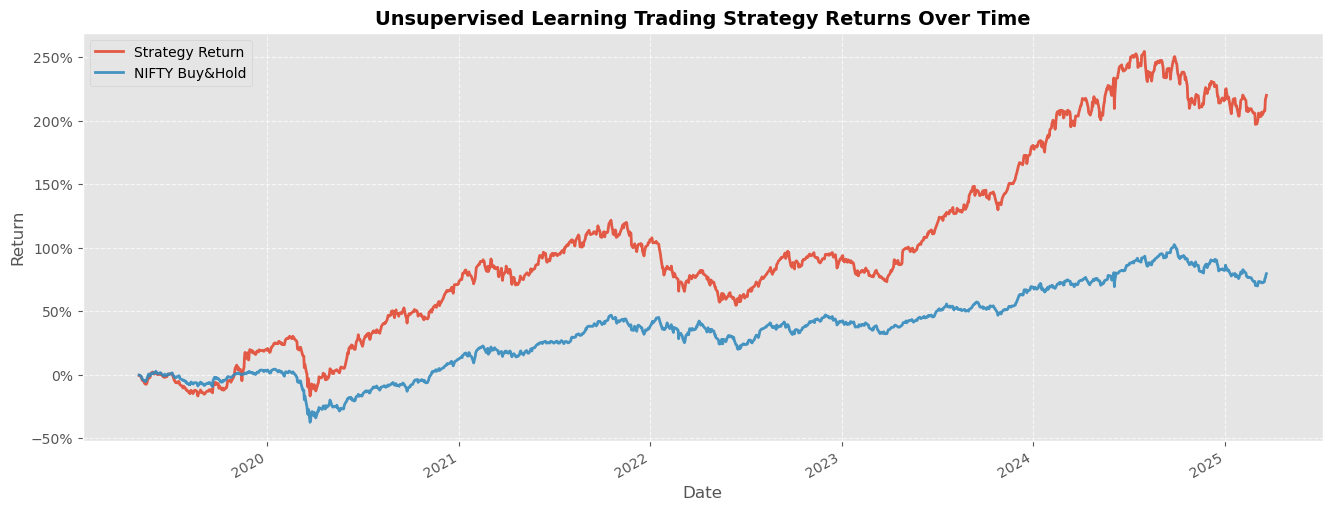

In [50]:
plt.style.use('ggplot')
import matplotlib.ticker as mtick
# Calculate cumulative returns
portfolio_cumulative_return = (1 + portfolio_df).cumprod() - 1

# Plot cumulative returns
ax = portfolio_cumulative_return.plot(figsize=(16, 6),
                                      linewidth=2,  
                                      alpha=0.9)    

# Title and labels
plt.title('Unsupervised Learning Trading Strategy Returns Over Time',
          fontsize=14, weight='bold')

plt.ylabel('Return', fontsize=12)
plt.xlabel('Date', fontsize=12)

# Format y-axis as percentage
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))

# Improve grid visibility
plt.grid(True, linestyle='--', alpha=0.7)

# Add legend for better understanding
plt.legend(portfolio_cumulative_return.columns, loc='upper left')

# Show the plot
plt.show()

## 9. Strategy Performance Metrics

[*********************100%***********************]  1 of 1 completed


✅ Portfolio vs Nifty Performance Metrics:
• Annualized Return (Strategy): 21.82%
• Annualized Return (Nifty): 10.36%
• Sharpe Ratio (Strategy): 0.78
• Sharpe Ratio (Nifty): 0.37
• Max Drawdown (Strategy): -36.08%
• Max Drawdown (Nifty): -40.04%


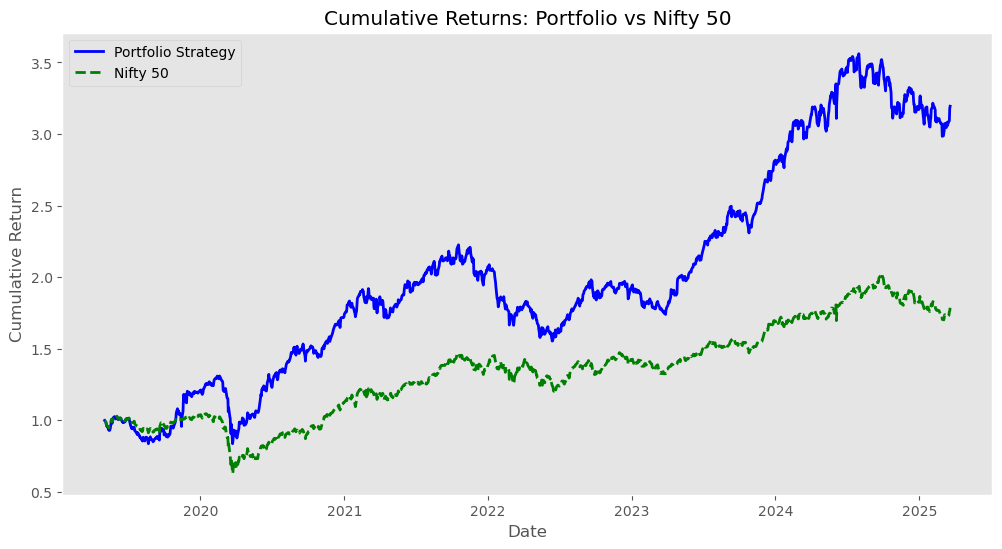

In [51]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Download Nifty Index Data as Benchmark
benchmark_ticker = "^NSEI"  
nifty_data = yf.download(tickers=benchmark_ticker,
                         start=portfolio_df.index[0],
                         end=portfolio_df.index[-1],
                         auto_adjust=True)

# Calculate Nifty Returns
nifty_returns = pd.DataFrame()
nifty_returns['Nifty Return'] = np.log(nifty_data['Close']).diff().dropna()
# Merge Portfolio and Nifty Returns
comparison_df = portfolio_df.merge(nifty_returns, left_index=True, right_index=True, how='inner')

# Recalculate Metrics for Both Strategy and Nifty

# Cumulative Returns
comparison_df['Cumulative Strategy'] = (1 + comparison_df['Strategy Return']).cumprod()
comparison_df['Cumulative Nifty'] = (1 + comparison_df['Nifty Return']).cumprod()

# 1. Annualized Returns
n_years = (comparison_df.index[-1] - comparison_df.index[0]).days / 365
annualized_strategy = comparison_df['Cumulative Strategy'].iloc[-1] ** (1 / n_years) - 1
annualized_nifty = comparison_df['Cumulative Nifty'].iloc[-1] ** (1 / n_years) - 1

# 2. Sharpe Ratio
mean_strategy = comparison_df['Strategy Return'].mean()
std_strategy = comparison_df['Strategy Return'].std()
mean_nifty = comparison_df['Nifty Return'].mean()
std_nifty = comparison_df['Nifty Return'].std()

risk_free_rate = 0.05 / 252  # Annual risk-free rate of 5%, adjusted for daily returns

sharpe_strategy = (mean_strategy - risk_free_rate) / std_strategy * np.sqrt(252)
sharpe_nifty = (mean_nifty - risk_free_rate) / std_nifty * np.sqrt(252)

# 3. Maximum Drawdown
peak_strategy = comparison_df['Cumulative Strategy'].cummax()
drawdown_strategy = (comparison_df['Cumulative Strategy'] - peak_strategy) / peak_strategy
max_drawdown_strategy = drawdown_strategy.min()

peak_nifty = comparison_df['Cumulative Nifty'].cummax()
drawdown_nifty = (comparison_df['Cumulative Nifty'] - peak_nifty) / peak_nifty
max_drawdown_nifty = drawdown_nifty.min()

# Display Portfolio vs Nifty Metrics
print("✅ Portfolio vs Nifty Performance Metrics:")
print(f"• Annualized Return (Strategy): {annualized_strategy:.2%}")
print(f"• Annualized Return (Nifty): {annualized_nifty:.2%}")
print(f"• Sharpe Ratio (Strategy): {sharpe_strategy:.2f}")
print(f"• Sharpe Ratio (Nifty): {sharpe_nifty:.2f}")
print(f"• Max Drawdown (Strategy): {max_drawdown_strategy:.2%}")
print(f"• Max Drawdown (Nifty): {max_drawdown_nifty:.2%}")

# Plot Portfolio vs Nifty Cumulative Returns
plt.figure(figsize=(12, 6))
plt.plot(comparison_df['Cumulative Strategy'], label='Portfolio Strategy', color='blue', linewidth=2)
plt.plot(comparison_df['Cumulative Nifty'], label='Nifty 50', color='green', linestyle='--', linewidth=2)
plt.title('Cumulative Returns: Portfolio vs Nifty 50')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid()
plt.show()


In [93]:
import pandas as pd
import numpy as np


# Get today's date (assuming it's the 1st of the month)
today = pd.to_datetime('today').replace(day=1)

# Determine the optimization window (past 12 months)
optimization_start = (today - pd.DateOffset(months=12)).strftime('%Y-%m-%d')
optimization_end = (today - pd.DateOffset(days=1)).strftime('%Y-%m-%d')

# Stocks selected last month
last_month = (today - pd.DateOffset(months=1)).strftime('%Y-%m-%d')
selected_stocks = fixed_dates.get(last_month, [])  # Get stocks for last month

# Get past 12 months of price data for selected stocks
optimization_df = new_df.loc[optimization_start:optimization_end, 'Adj Close'][selected_stocks]

# Try Max Sharpe Optimization
success = False
try:
    weights = optimize_weights(prices=optimization_df, lower_bound=round(1/(len(selected_stocks)*2), 4))
    weights = pd.DataFrame(weights, index=pd.Series(0))
    success = True
except:
    print(f'Max Sharpe Optimization failed for {today.strftime("%Y-%m-%d")}, using Equal Weights')

# If optimization fails, use equal weights
if not success:
    weights = pd.DataFrame([1/len(selected_stocks) for _ in range(len(selected_stocks))],
                           index=selected_stocks,
                           columns=pd.Series(0)).T

# Convert weights to percentages
weights_percentage = (weights.T * 100).round(2)
weights_percentage.columns = ['Weight (%)']

# Assuming total capital is ₹10,00,000, allocate capital
total_capital = 10_00_000  # ₹10 lakh
capital_allocation = (weights.T * total_capital).round(2)
capital_allocation.columns = ['Allocated Capital (₹)']

# Final allocation table
allocation_table = pd.concat([weights_percentage, capital_allocation], axis=1)

print("\nStock Allocation for the Current Month:")
print(f"Total capital: {total_capital}")
print(allocation_table)



Stock Allocation for the Current Month:
Total capital: 1000000
               Weight (%)  Allocated Capital (₹)
BAJAJFINSV.NS       10.00               100000.0
BAJFINANCE.NS       10.00               100000.0
COALINDIA.NS        10.00               100000.0
EICHERMOT.NS        10.00               100000.0
HINDUNILVR.NS       10.00               100000.0
KOTAKBANK.NS        10.00               100000.0
MARUTI.NS           10.00               100000.0
TITAN.NS             5.45                54500.0
ULTRACEMCO.NS       10.00               100000.0
WIPRO.NS            10.00               100000.0
IRCTC.NS             4.55                45500.0
